## Dependencies

In [1]:
install_packs = F
if(install_packs){
    install.packages("e1071")
    install.packages("caret")
    install.packages("psych")
    install.packages("plyr")
    install.packages("DMwR")
    install.packages("corrplot")
    install.packages("rpart")
    install.packages("randomForest")
    install.packages("FactoMineR")
    install.packages("factoextra")
    install.packages("neuralnet")
    install.packages("rjson")
    install.packages("keras")
    install.packages("mltools")
    install.packages("multiROC")
}

In [2]:
library(e1071)
library(caret)
library(corrplot)
library(psych)
library(plyr)
library(DMwR)
library(rpart)
library(randomForest)
library(FactoMineR)
library(factoextra)
library(neuralnet)
library(jsonlite)
library(keras)
library(mltools)
library(data.table)
library(multiROC)

Loading required package: lattice

Loading required package: ggplot2

corrplot 0.84 loaded


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘DMwR’


The following object is masked from ‘package:plyr’:

    join


The following object is masked from ‘package:psych’:

    crossValidation


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:psych’:

    outlier


The following object is masked from ‘package:ggplot2’:

    margin


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘mltools’


The following object is masked from ‘package:e1071’:

    skewness




#### Funzione utile 


In [3]:
shuffle <- function(data) {
    rows <- sample(nrow(data))
    output <- data[rows,]
    return(output)
}

## Caricamento dataset

In [4]:
data = read.table(file = 'dataset/songDb.tsv',sep = '\t',header = TRUE,fill = TRUE, stringsAsFactors = FALSE)
dim(data)

[1] 131562     20

total genres: 626

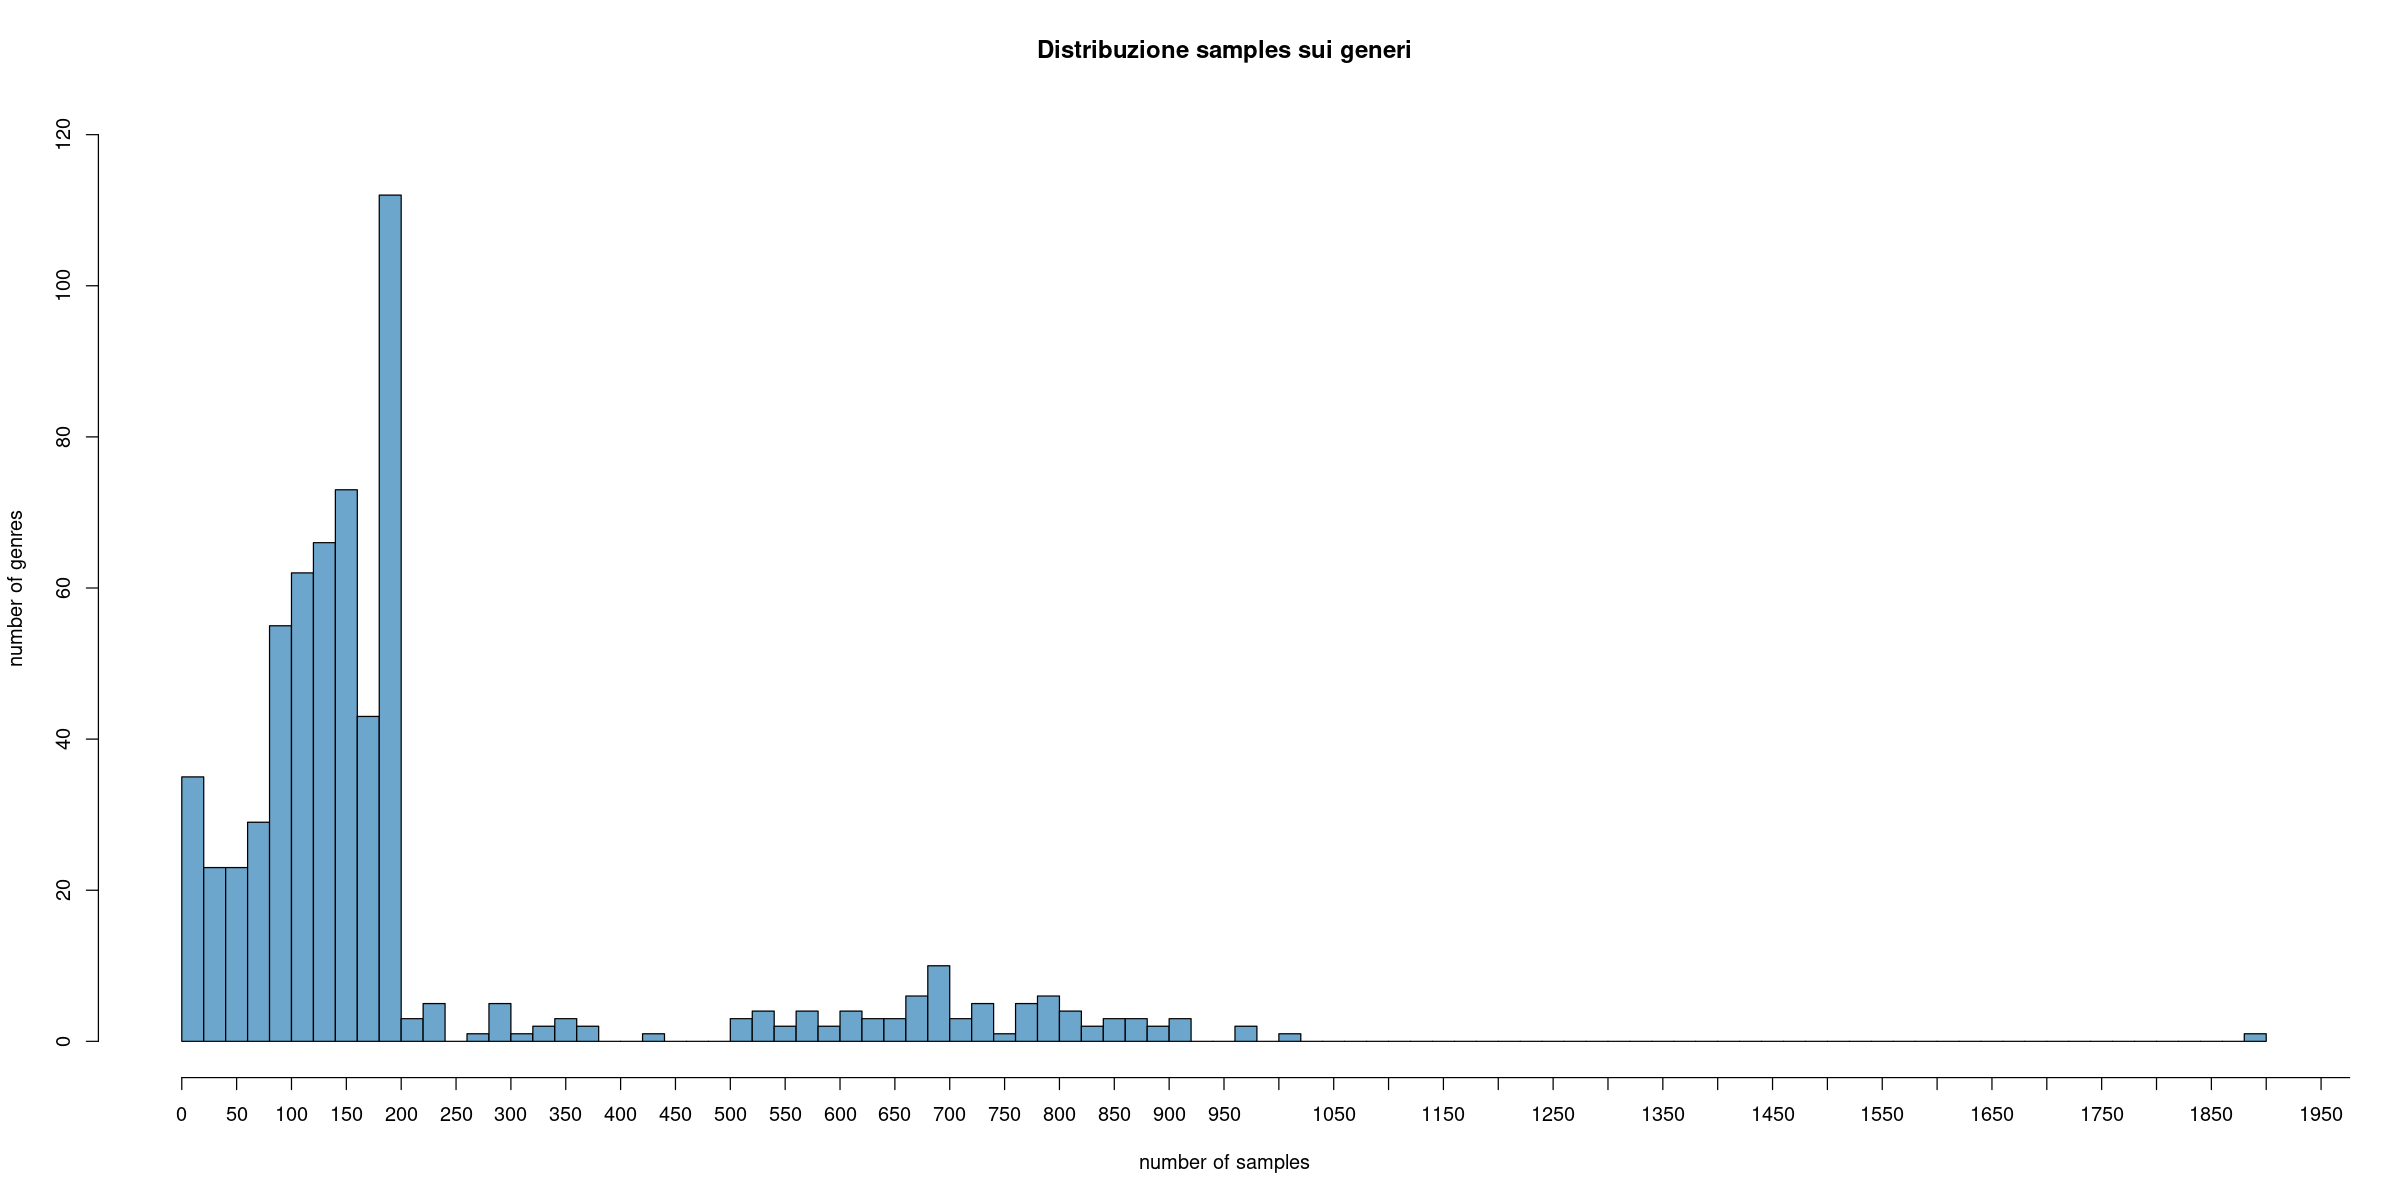

In [5]:
# distributìzione dei samples sui vari generi musicali
options(repr.plot.width=20, repr.plot.height=10)
dist <-data.frame(table(data$Genre))
cat("total genres:", nrow(dist))
hist(dist$Freq,main="Distribuzione samples sui generi", col = 'skyblue3', breaks = 100,
     xlim=c(0,1900), ylim=c(0,120), xlab="number of samples", ylab="number of genres", xaxt="n")
axis(side=1, at=seq(0,2000, 50), labels=seq(0,2000,50))

# Data preparation

###  raggruppamento per supergruppi

In [6]:
# leggo il json che contiene il raggruppamento manuale dei 626 diversi generi in 18 supergeneri
json <- fromJSON('dataset/genres.json')
metal_list <- json$metal_list
rock_list <- json$rock_list
jazz_list <- json$jazz_list
folk_list <- json$folk_list
indie_list <- json$indie_list
punk_list <- json$punk_list
pop_list <- json$pop_list
hiphop_list <-json$hiphop_list
house_list <- json$house_list
rap_list <- json$rap_list
ambient_list <- json$ambient_list
techno_list <- json$techno_list
trance_list <- json$trance_list
classical_list <- json$classical_list
latin_list <- json$latin_list
country_list <- json$country_list
gospel_list <- json$gospel_list
funk_list <-json$funk_list

# raggruppamento dei generi
data$Genre[data$Genre %in% ambient_list] = "ambient"
data$Genre[data$Genre %in% classical_list] = "classical"
data$Genre[data$Genre %in% country_list] = "country"
data$Genre[data$Genre %in% folk_list] = "folk"
data$Genre[data$Genre %in% funk_list] = "funk"
data$Genre[data$Genre %in% gospel_list] = "gospel"
data$Genre[data$Genre %in% hiphop_list] = "hiphop"
data$Genre[data$Genre %in% indie_list] = "indie"
data$Genre[data$Genre %in% jazz_list] = "jazz"
data$Genre[data$Genre %in% latin_list] = "latin"
data$Genre[data$Genre %in% metal_list] = "metal"
data$Genre[data$Genre %in% pop_list] = "pop"
data$Genre[data$Genre %in% punk_list] = "punk"
data$Genre[data$Genre %in% rap_list] = "rap"
data$Genre[data$Genre %in% rock_list] = "rock"
data$Genre[data$Genre %in% techno_list] = "techno"
data$Genre[data$Genre %in% trance_list] = "trance"
data$Genre[data$Genre %in% house_list] = "house"

In [7]:
# seleziono i supergeneri che mi interessano
genres = c("ambient","classical","country","folk","funk","gospel","hiphop","indie","jazz","latin","metal","pop","punk","rap","rock","techno","trance","house")
#genres = c("latin", "metal", "hiphop", "jazz", "rock")
#genres = c("punk","latin", "jazz")
#genres = c("classical", "latin")

data <- data[(data$Genre %in% genres), ]

In [8]:
# assegno il tipo corretto ad alcune features mal tipizzate
numerical_vars <- c("Danceability","Energy","Loudness","Speechness","Acousticness","Instrumentalness","Liveness","Valence","Tempo","Duration_ms")
categorical_vars <- c("Key","Mode","time_signature")
predictors <- c("Danceability","Energy","Key","Loudness","Mode","Speechness","Acousticness","Instrumentalness","Liveness","Valence","Tempo","Duration_ms","time_signature")
all_features <- c(predictors, "Genre")

# changing variables type
data = data[,all_features]
data$Key = factor(data$Key)
data$Mode = factor(data$Mode)
data$time_signature = factor(data$time_signature)
data$Genre = factor(data$Genre)
data$Tempo = as.integer(data$Tempo)

### scaling dataset

In [9]:
data <- cbind(scale(data[,numerical_vars]), data[,categorical_vars], Genre=data$Genre)

###  distribuzione classe target (after grouping)


  ambient classical   country      folk      funk    gospel    hiphop     house 
     1550       783       790      5221       569       966      5191      3375 
    indie      jazz     latin     metal       pop      punk       rap      rock 
     9592      2720       965      9065     10947      4582      2132      9648 
   techno    trance 
     2085      1776 

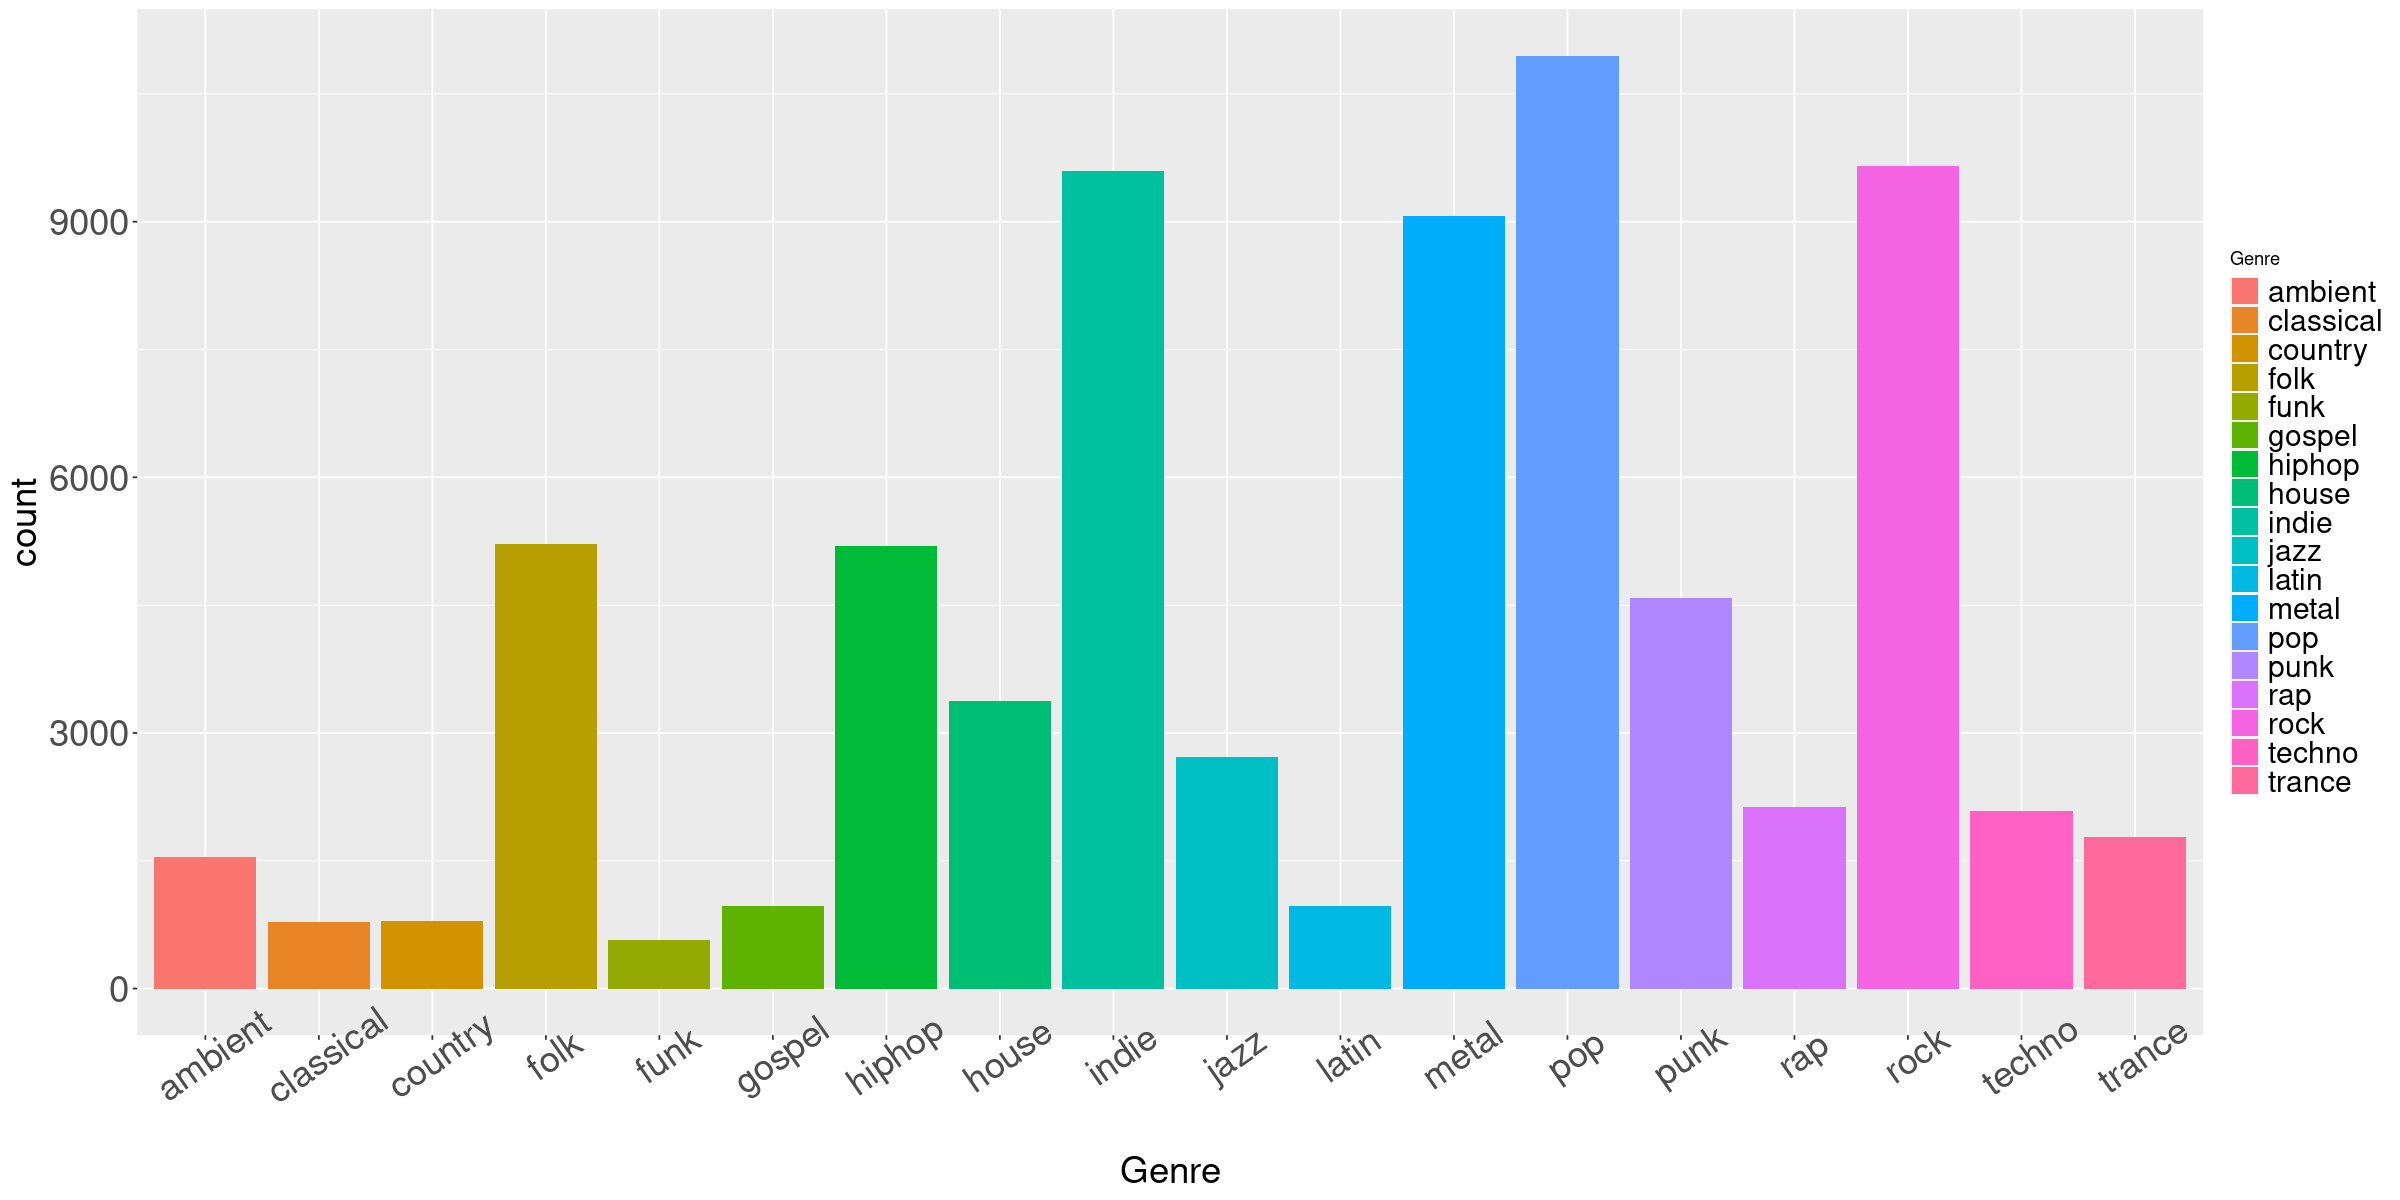

In [10]:
# verifica distribuzione dei samples tispetto ai generi
table(data$Genre) 
ggplot(data, aes(Genre))+ geom_bar(aes(fill = Genre)) + 
    theme(legend.text=element_text(size=18), axis.text=element_text(size=rel(2)), axis.text.x=element_text(angle=35), axis.title=element_text(size=rel(2)))

# Data exploration 

### correlazione tra le features numeriche

,Danceability,Energy,Loudness,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms
Danceability,1.00000000,-0.040810854,0.08004511,0.15188892,-0.02591785,-0.17018030,-0.124368281,0.427326620,-0.139806119,-0.109150815
Energy,-0.04081085,1.000000000,0.75492717,0.11783733,-0.69912479,-0.07860522,0.192963978,0.185332258,0.205406202,-0.007284161
Loudness,0.08004511,0.754927174,1.00000000,0.10603564,-0.55778104,-0.32020131,0.126522594,0.200626084,0.137208910,-0.104818593
Speechness,0.15188892,0.117837325,0.10603564,1.00000000,-0.06101715,-0.12944831,0.088712551,0.062744458,0.032936219,-0.093053230
Acousticness,-0.02591785,-0.699124794,-0.55778104,-0.06101715,1.00000000,0.02082462,-0.110024614,-0.042932426,-0.166624257,-0.075233707
Instrumentalness,-0.17018030,-0.078605223,-0.32020131,-0.12944831,0.02082462,1.00000000,-0.040978996,-0.327116441,0.015586740,0.338084749
Liveness,-0.12436828,0.192963978,0.12652259,0.08871255,-0.11002461,-0.04097900,1.000000000,-0.006713244,0.035184801,-0.003978372
Valence,0.42732662,0.185332258,0.20062608,0.06274446,-0.04293243,-0.32711644,-0.006713244,1.000000000,0.024962422,-0.259691945
Tempo,-0.13980612,0.205406202,0.13720891,0.03293622,-0.16662426,0.01558674,0.035184801,0.024962422,1.000000000,-0.004633313
Duration_ms,-0.10915082,-0.007284161,-0.10481859,-0.09305323,-0.07523371,0.33808475,-0.003978372,-0.259691945,-0.004633313,1.000000000


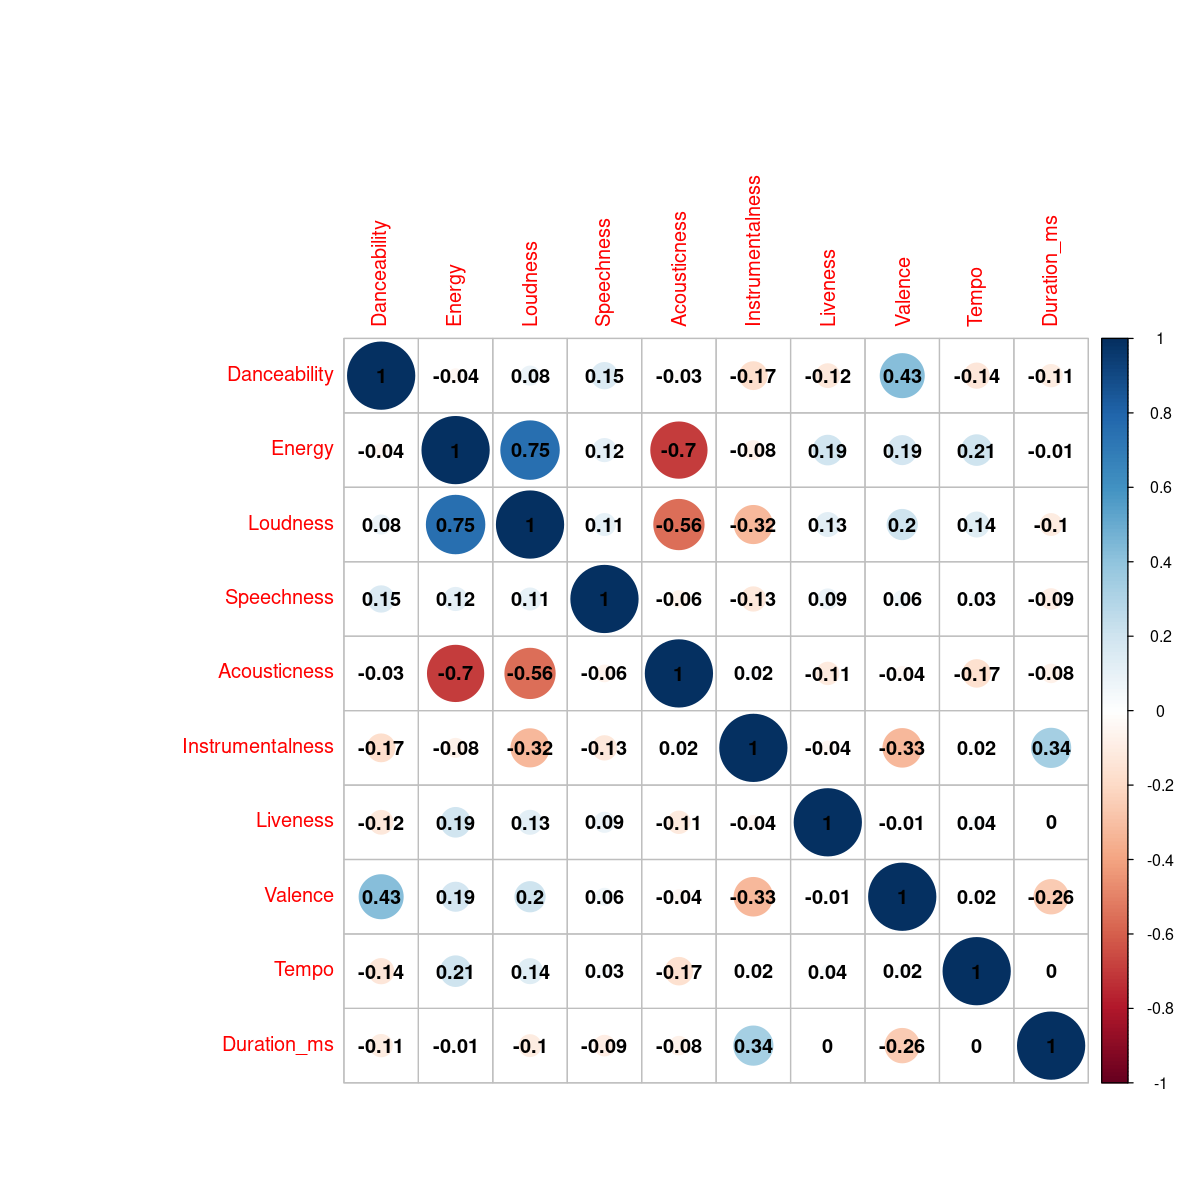

In [11]:
options(repr.plot.width=10, repr.plot.height=10)
dataset.cor = cor(data[,numerical_vars])
correlationMatrix =  corrplot(dataset.cor, addCoef.col = T)
correlationMatrix

### Verifico la separazione delle classi in base a coppie di features (su dataset undersampled)

In [12]:
undersampling_data <- function(data, limit){
    all_genres <- unique(data$Genre)
    undersampled <- data.frame()
  
    for(genre in all_genres){
        if(nrow(data[data$Genre==genre,])> limit)
            undersampled = rbind(undersampled, head(shuffle(data[data$Genre==genre,]), limit) )
        else
            undersampled = rbind(undersampled, data[data$Genre==genre,] )
    }
    return(undersampled)
}

# Faccio un undersamoling di tutte le classi fino a 1000 allo scopo che i plot non vengano
# monopolizzati dalle classi più numerose poichè sono fortemente sbilanciate
under <- undersampling_data(data, 1000)

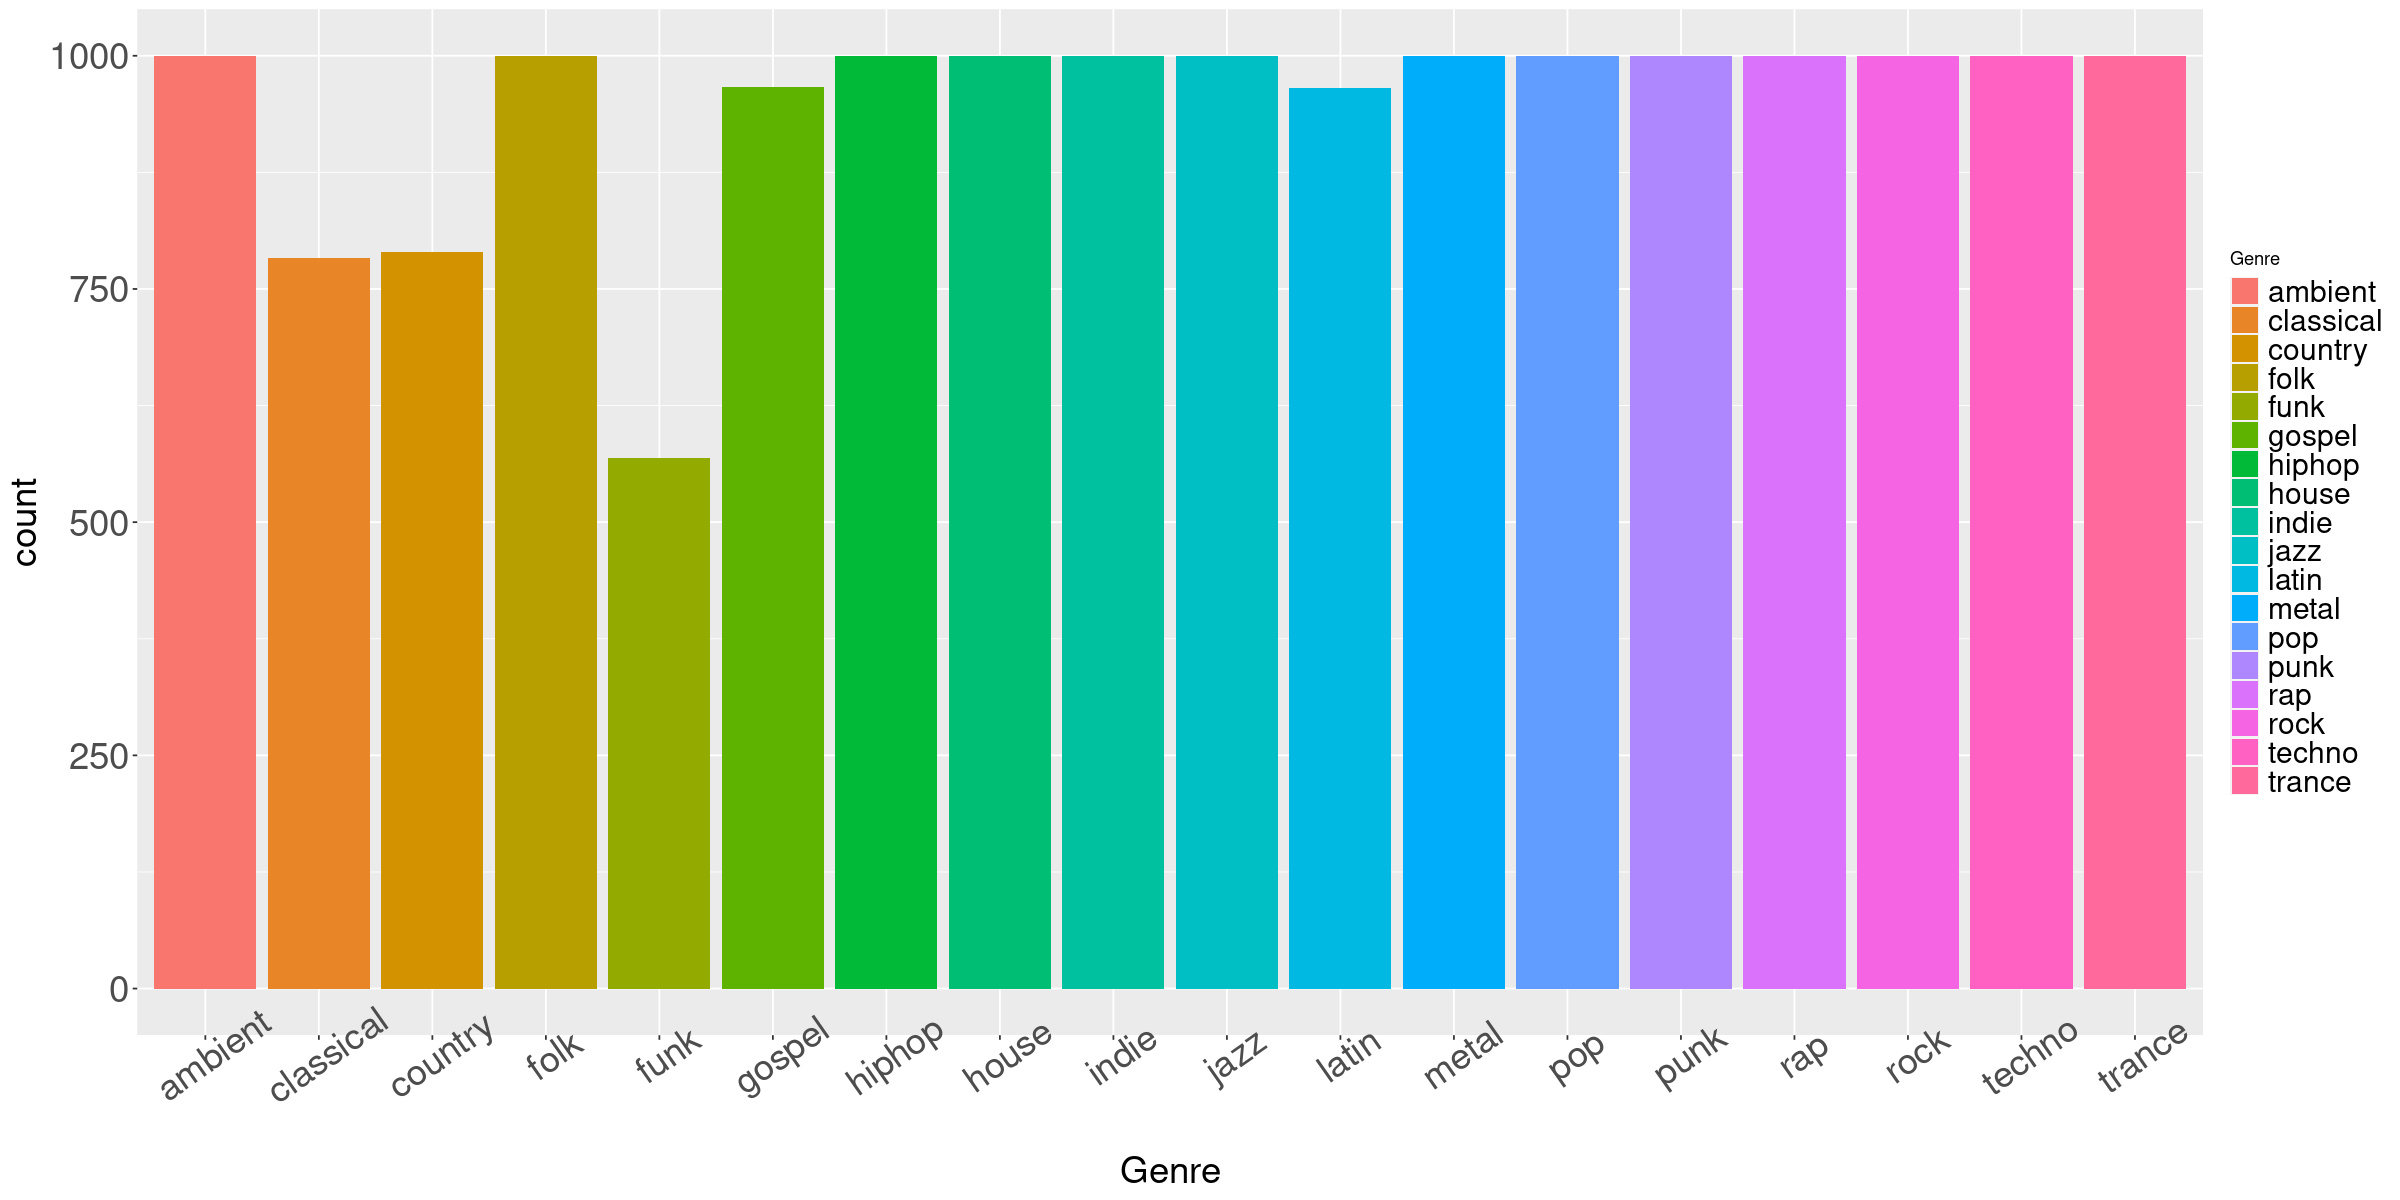

In [13]:
# verifica distribuzione dopo undersampling per pplotting
options(repr.plot.width=20, repr.plot.height=10)
ggplot(under, aes(Genre)) + geom_bar(aes(fill = Genre)) +
    theme(legend.text=element_text(size=18), axis.text=element_text(size=rel(2)), axis.text.x=element_text(angle=35), axis.title=element_text(size=rel(2)))

In [14]:
# options(repr.plot.width=55, repr.plot.height=55)
# featurePlot(x = under[,numerical_vars], y = under$Genre, plot = "pairs", auto.key=list(columns=10))

In [15]:
options(repr.plot.width=10, repr.plot.height=10)

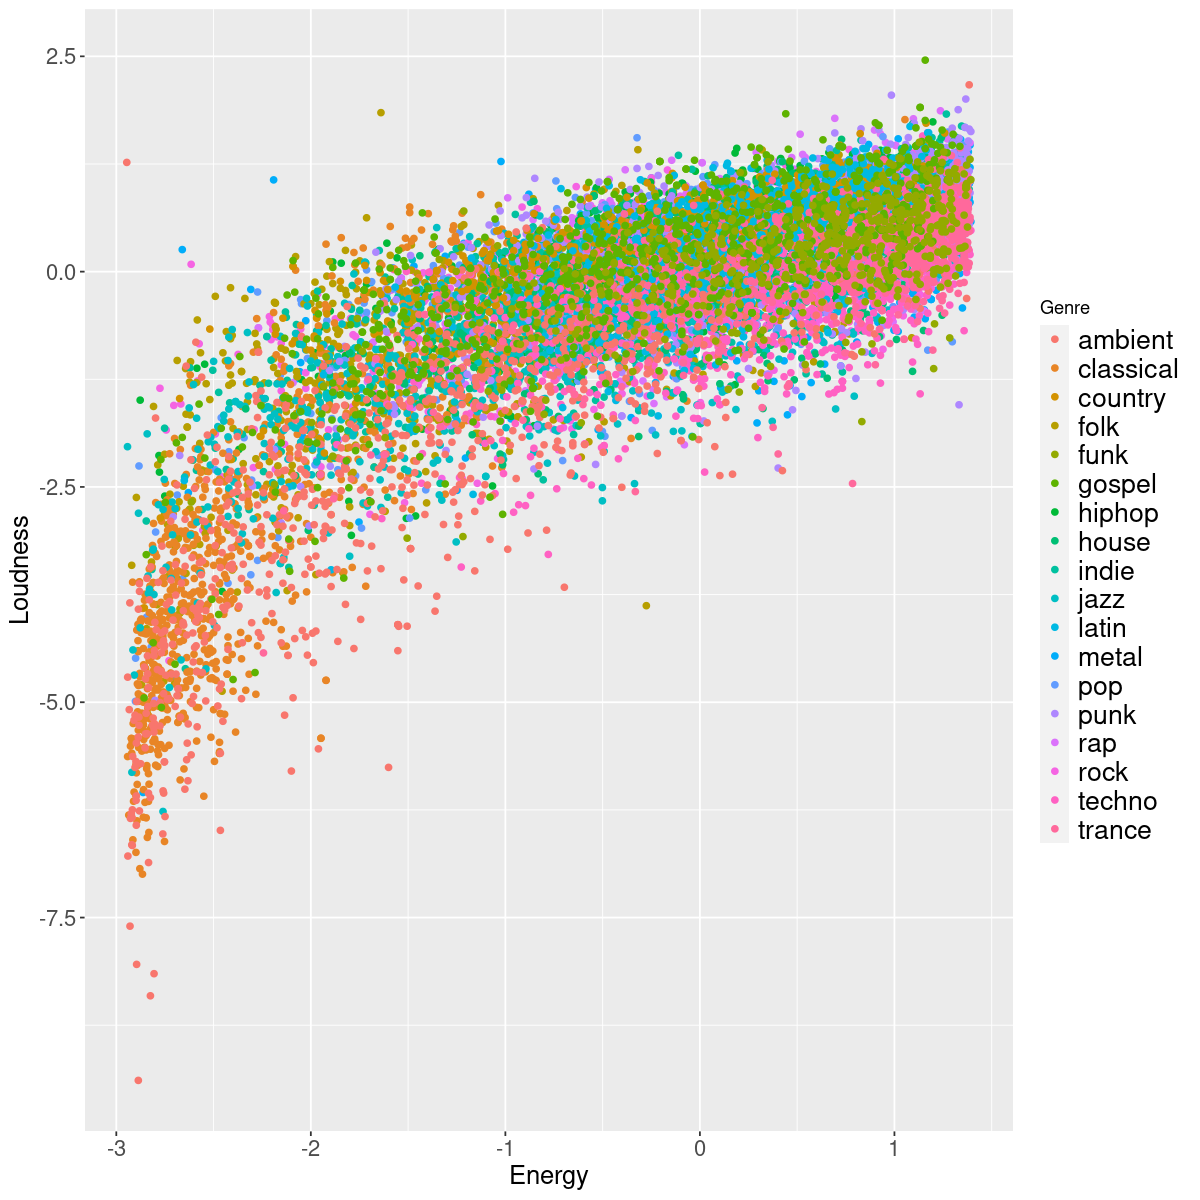

In [16]:
# no evidenti cluster
ggplot(under, aes(x = Energy, y = Loudness, color = Genre)) + geom_point() +
theme(legend.text=element_text(size=16), axis.text=element_text(size=rel(1.2)), axis.title=element_text(size=rel(1.4)))

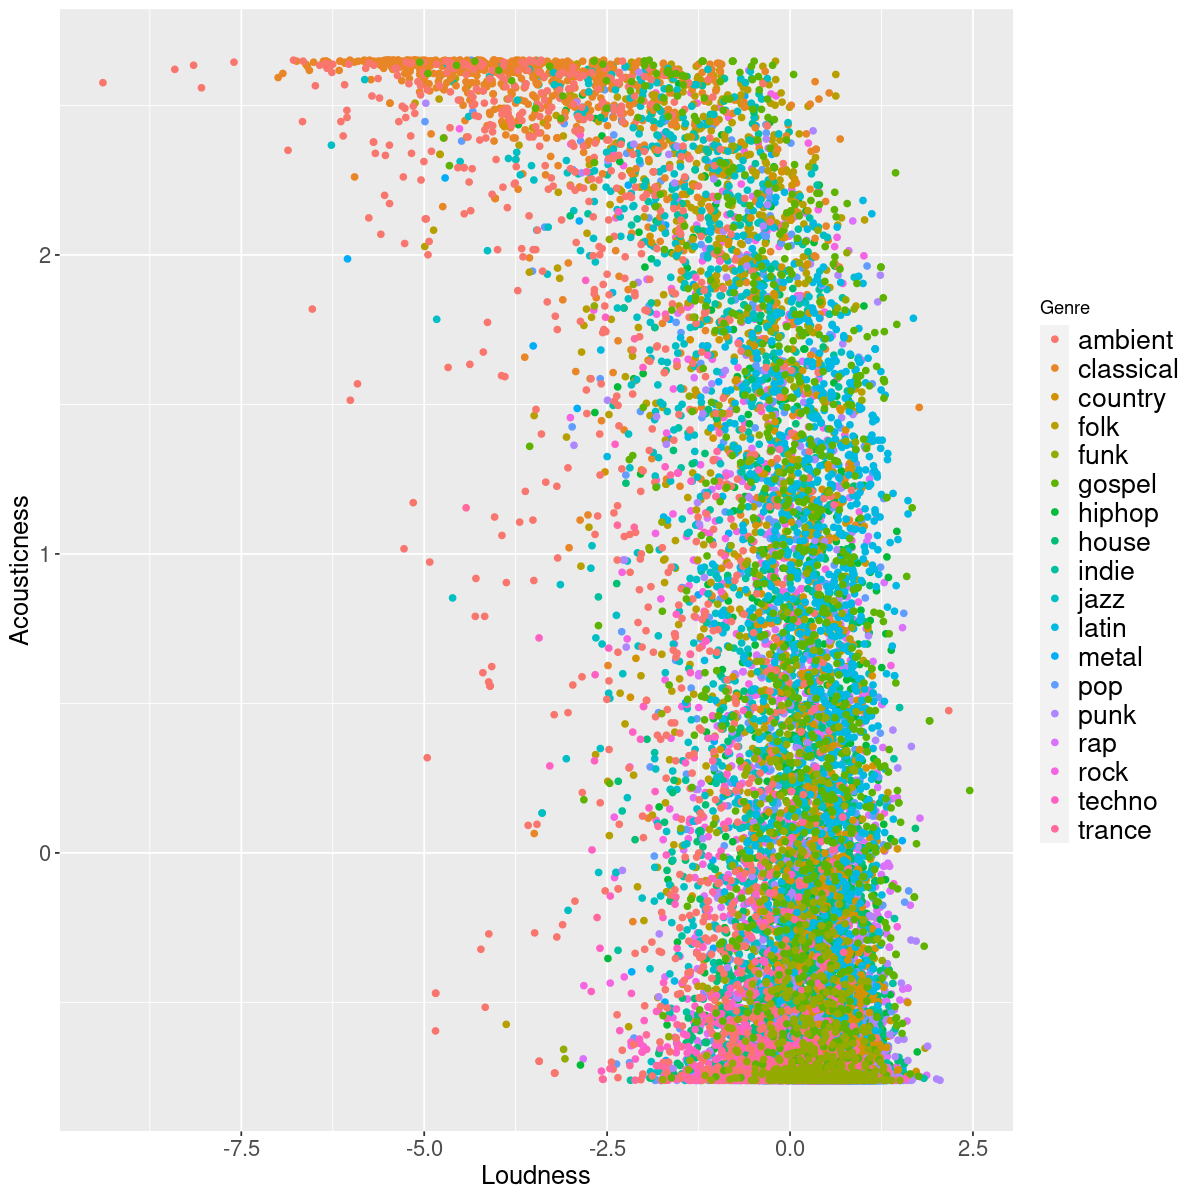

In [17]:
# no evidenti cluster
ggplot(under, aes(x = Loudness, y = Acousticness, color = Genre)) + geom_point() +
theme(legend.text=element_text(size=16), axis.text=element_text(size=rel(1.2)), axis.title=element_text(size=rel(1.4)))

Warning message:
“Removed 184 rows containing missing values (geom_point).”


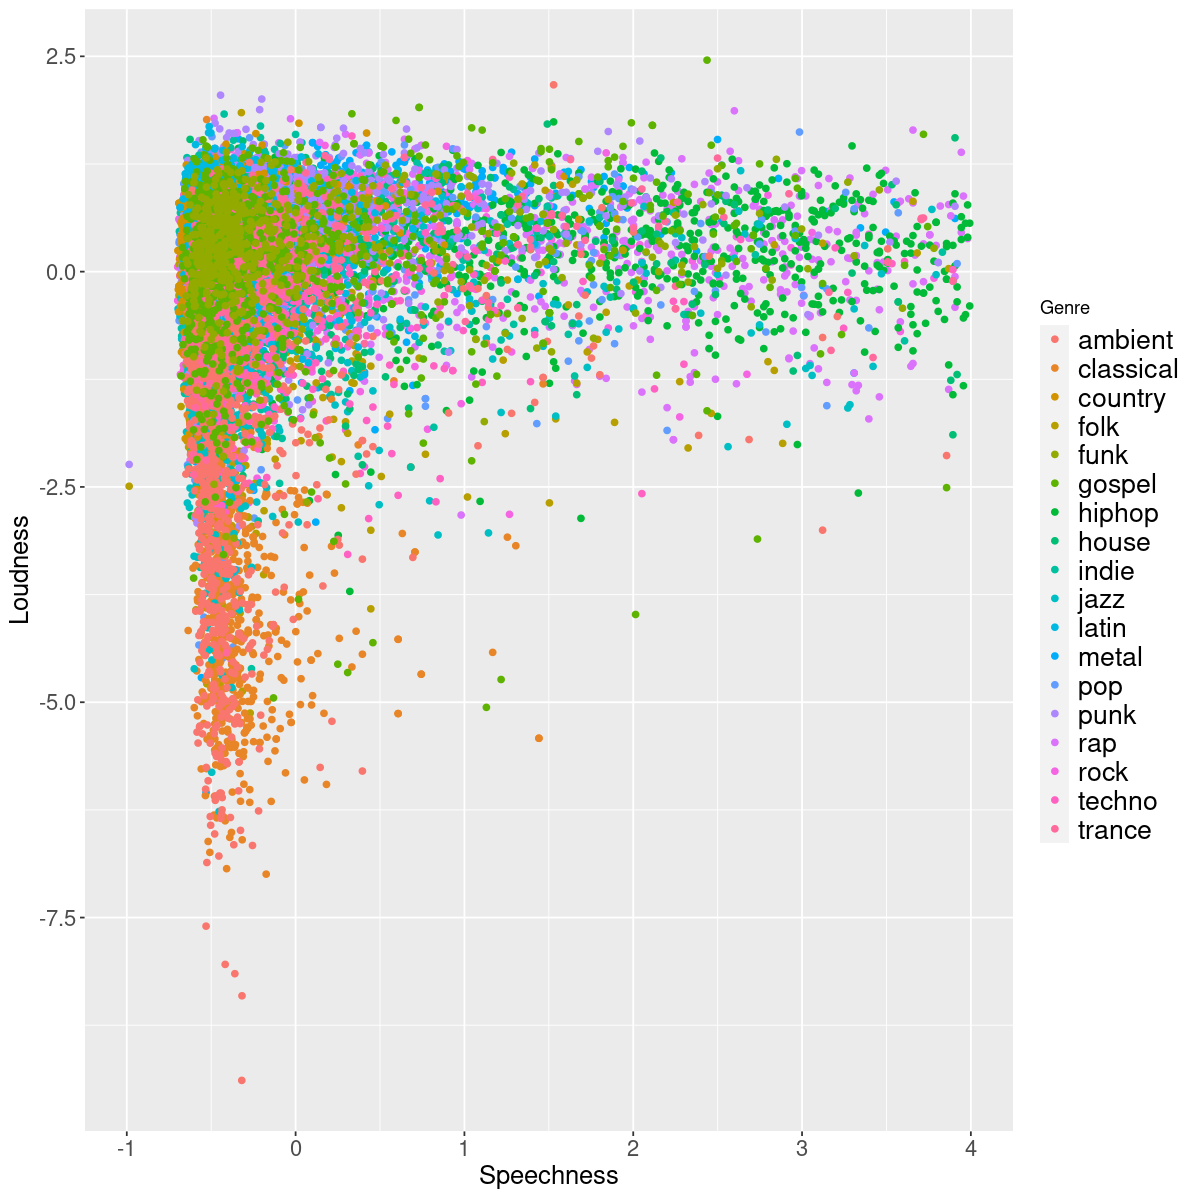

In [18]:
# no evidenti cluster
ggplot(under, aes(x = Speechness, y = Loudness, color = Genre)) + geom_point()+ scale_x_continuous(limits = c(-1, 4)) +
theme(legend.text=element_text(size=16), axis.text=element_text(size=rel(1.2)), axis.title=element_text(size=rel(1.4)))

### Considerazioni su features categoriche

In [19]:
options(repr.plot.width=16, repr.plot.height=7)

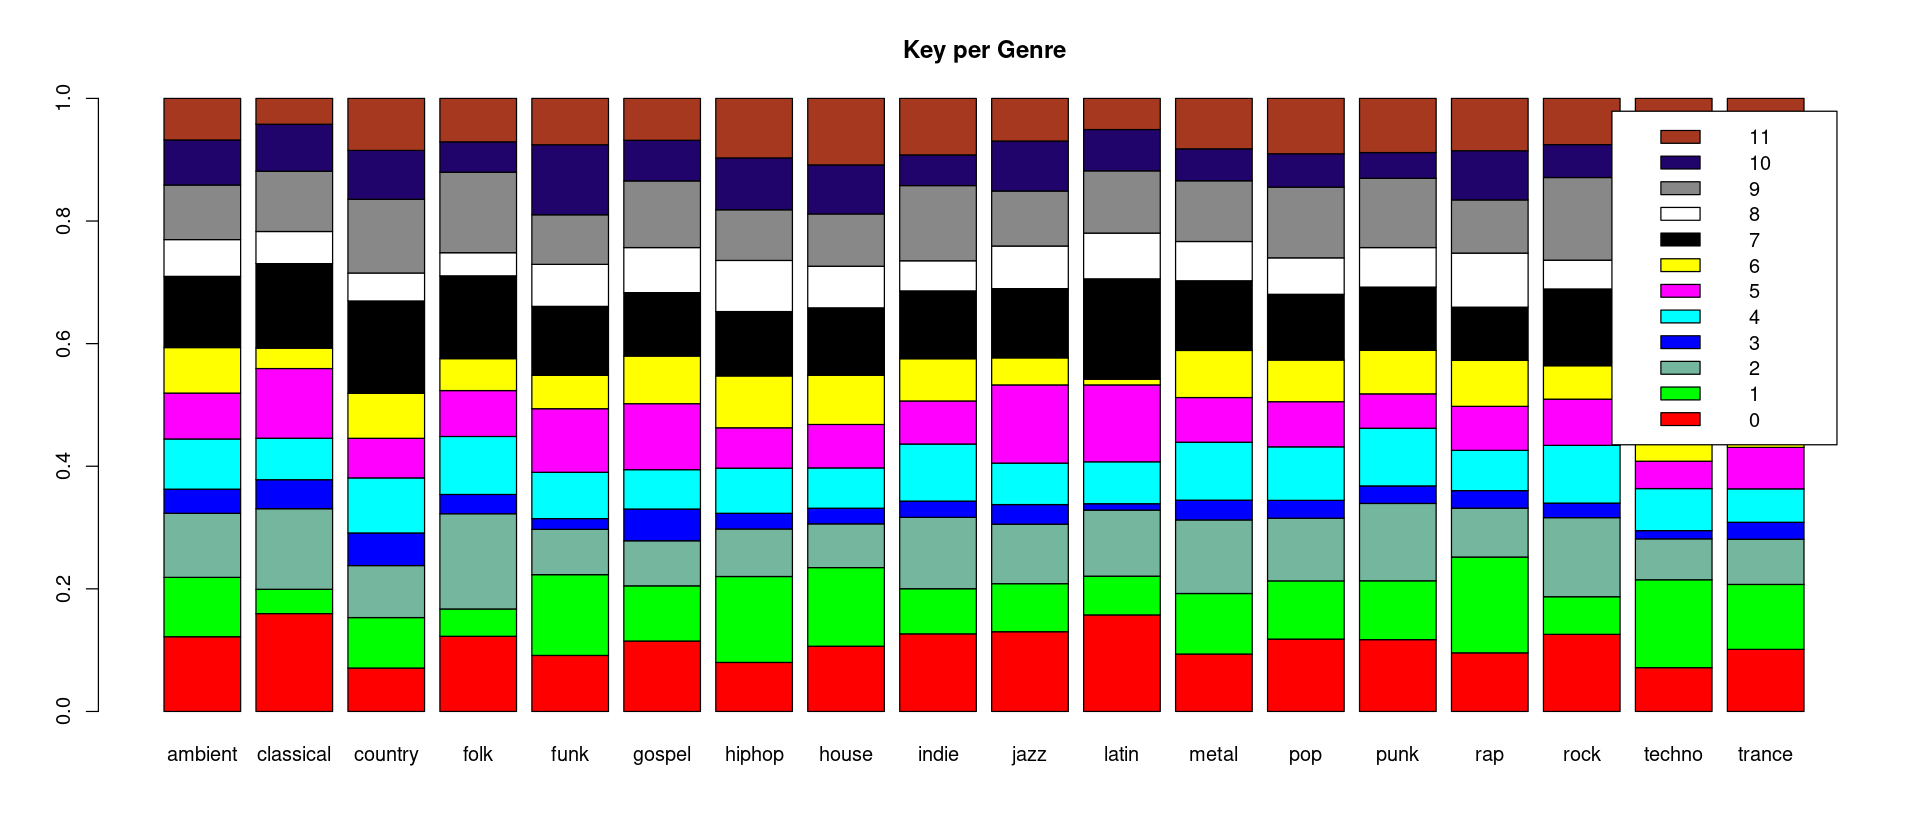

In [20]:
barplot(prop.table(table(data$Key, data$Genre),margin=2), legend = levels(data$Key), main = "Key per Genre",
        col = c("#FF0000", "#00FF00", "#75b79e", "#0000FF", "#00FFFF", "#FF00FF", "#FFFF00",
                "#000000", "#FFFFFF", "#888888", "#21046B", "#A6381F", "#094366"))


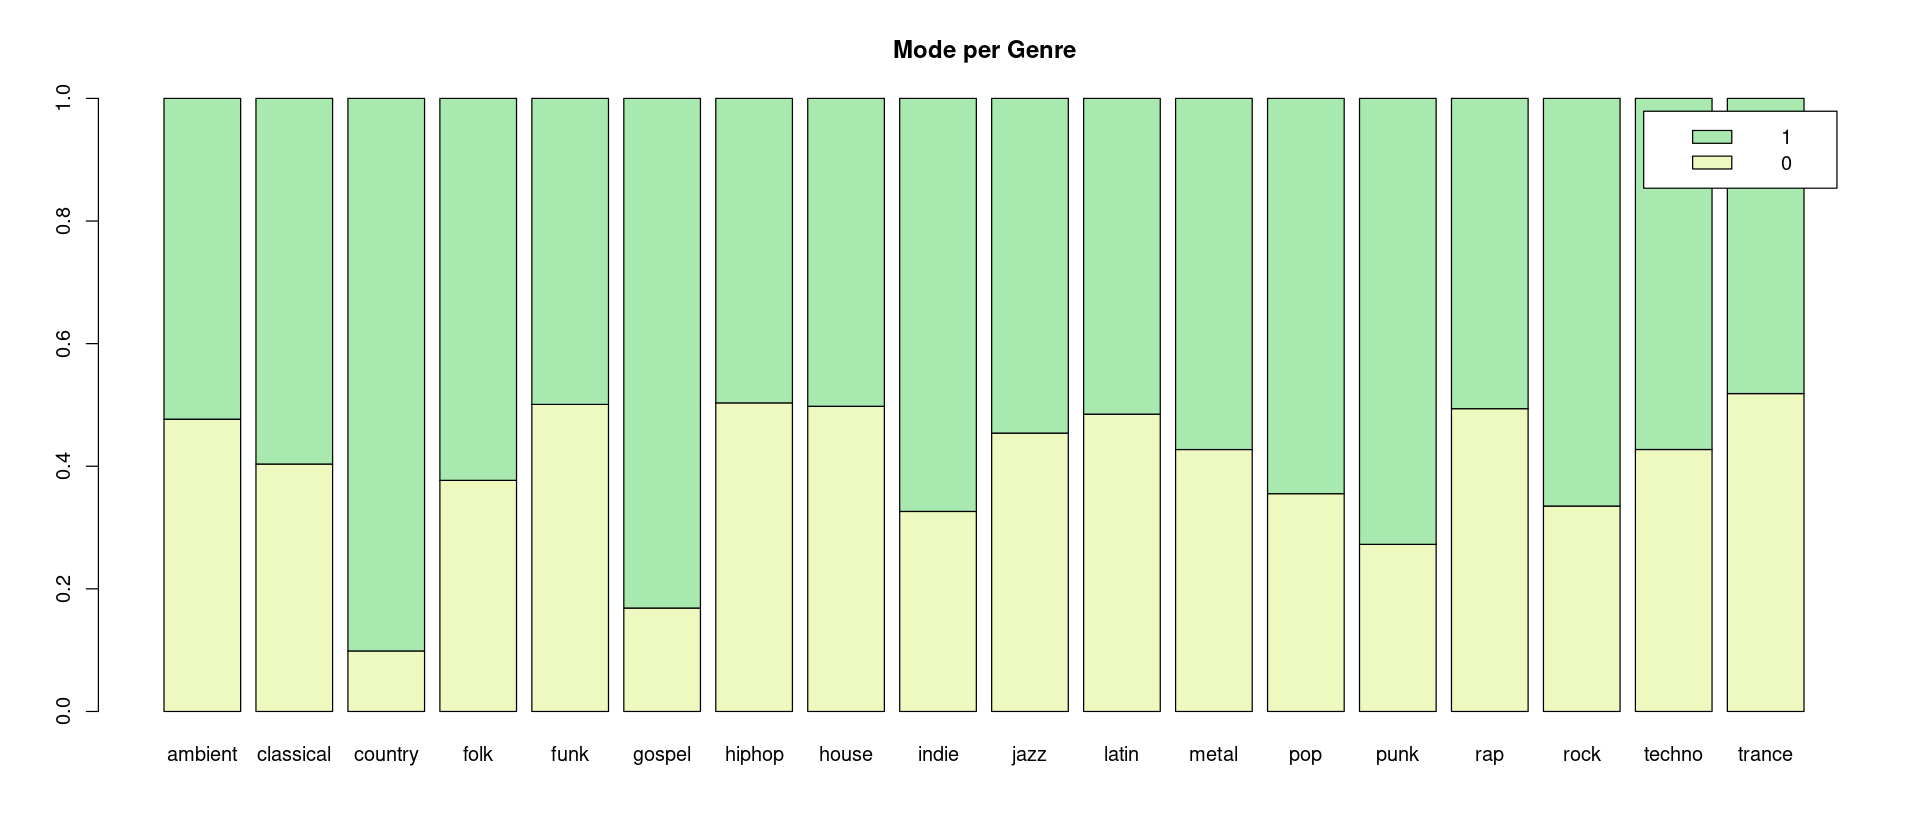

In [21]:
# country, gospel e punk valgono per lo più 1 
barplot(prop.table(table(data$Mode, data$Genre),margin=2),
        legend = levels(data$Mode), main = "Mode per Genre",col = c("#eef9bf", "#a7e9af"))    

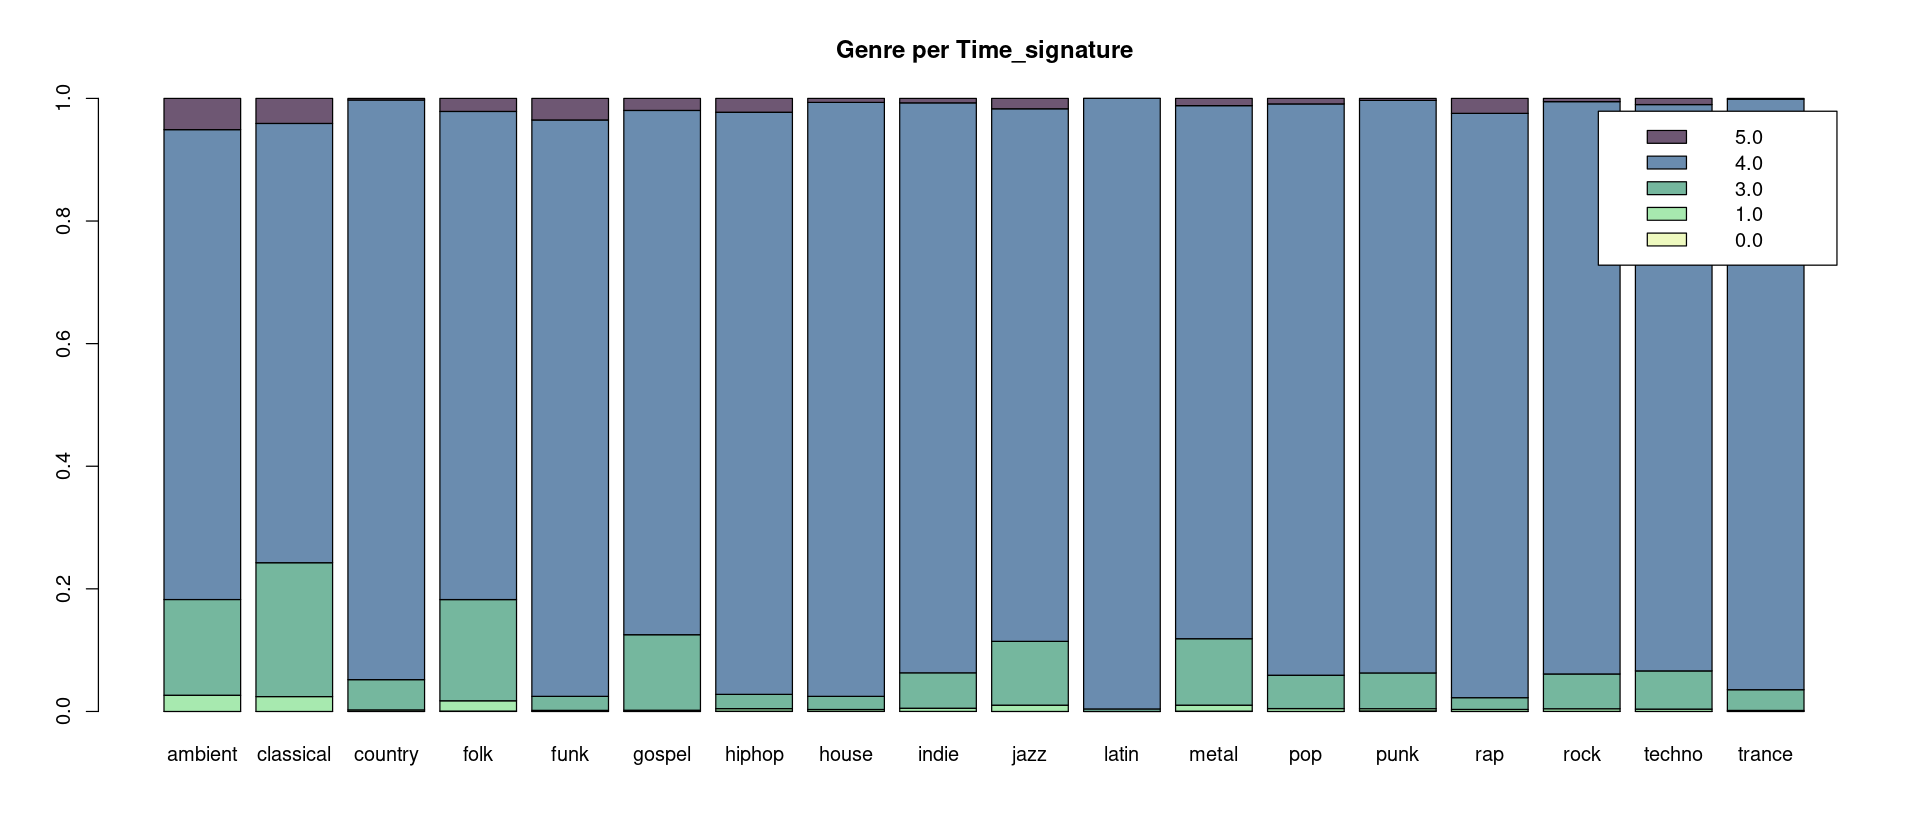

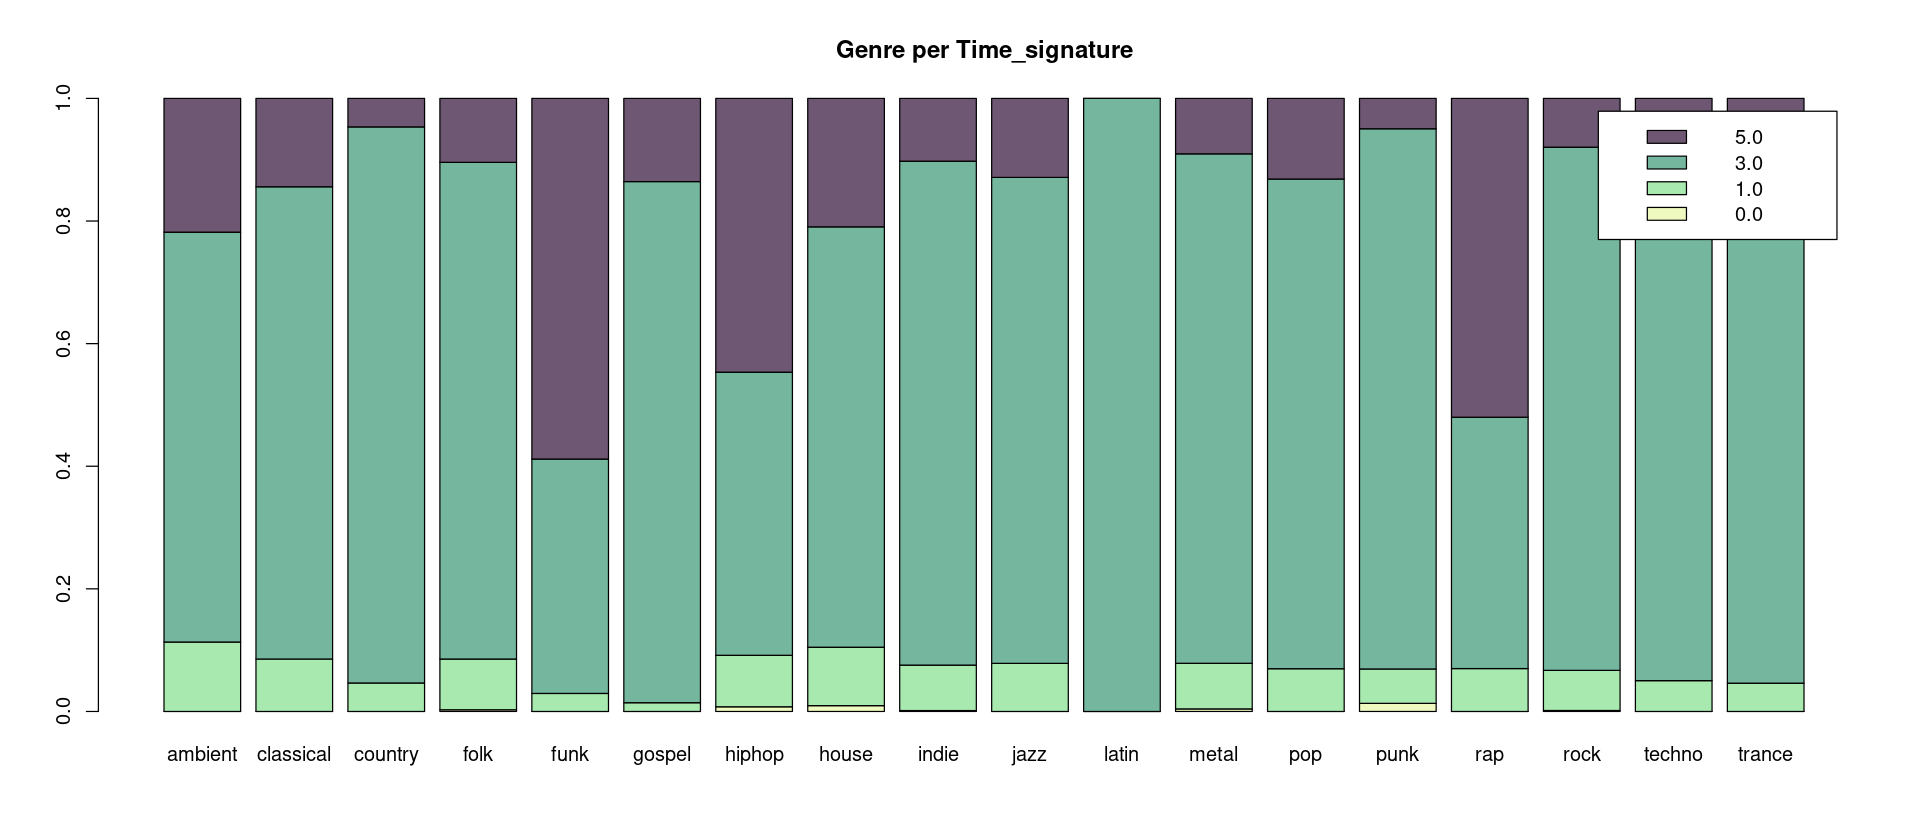

In [22]:
# maggioranza dei brani vale 4 --> non molto di aiuto
barplot(prop.table(table(data$time_signature, data$Genre),margin=2),
        legend = levels(data$time_signature), main = "Genre per Time_signature", 
        col = c("#eef9bf", "#a7e9af", "#75b79e", "#6a8caf", "#6e5773"))  

temp <- data[data$time_signature != "4.0",]
temp <- droplevels(temp)

# se togliessimo i brani che valgono 4? --> scopriamo che latin può essere solo 3 o 4
barplot(prop.table(table(temp$time_signature, temp$Genre),margin=2),
        legend = levels(temp$time_signature), main = "Genre per Time_signature", 
        col = c("#eef9bf", "#a7e9af", "#75b79e", "#6e5773"))  


### Analisi PCA

In [23]:
numerical_vars <- c("Danceability","Energy","Loudness","Speechness","Acousticness","Instrumentalness","Liveness","Valence","Tempo","Duration_ms")
categorical_vars <- c("Key","Mode","time_signature")
res.pca <- PCA(data[,numerical_vars], ncp=8, graph=FALSE)

In [24]:
options(repr.plot.width=8, repr.plot.height=8)

,eigenvalue,variance.percent,cumulative.variance.percent
Dim.1,2.6102279,26.102279,26.10228
Dim.2,1.8186168,18.186168,44.28845
Dim.3,1.0968470,10.968470,55.25692
Dim.4,1.0043589,10.043589,65.30051
Dim.5,0.9378188,9.378188,74.67869
Dim.6,0.8277983,8.277983,82.95668
Dim.7,0.6555169,6.555169,89.51185
Dim.8,0.5067282,5.067282,94.57913
Dim.9,0.3758938,3.758938,98.33807
Dim.10,0.1661934,1.661934,100.00000


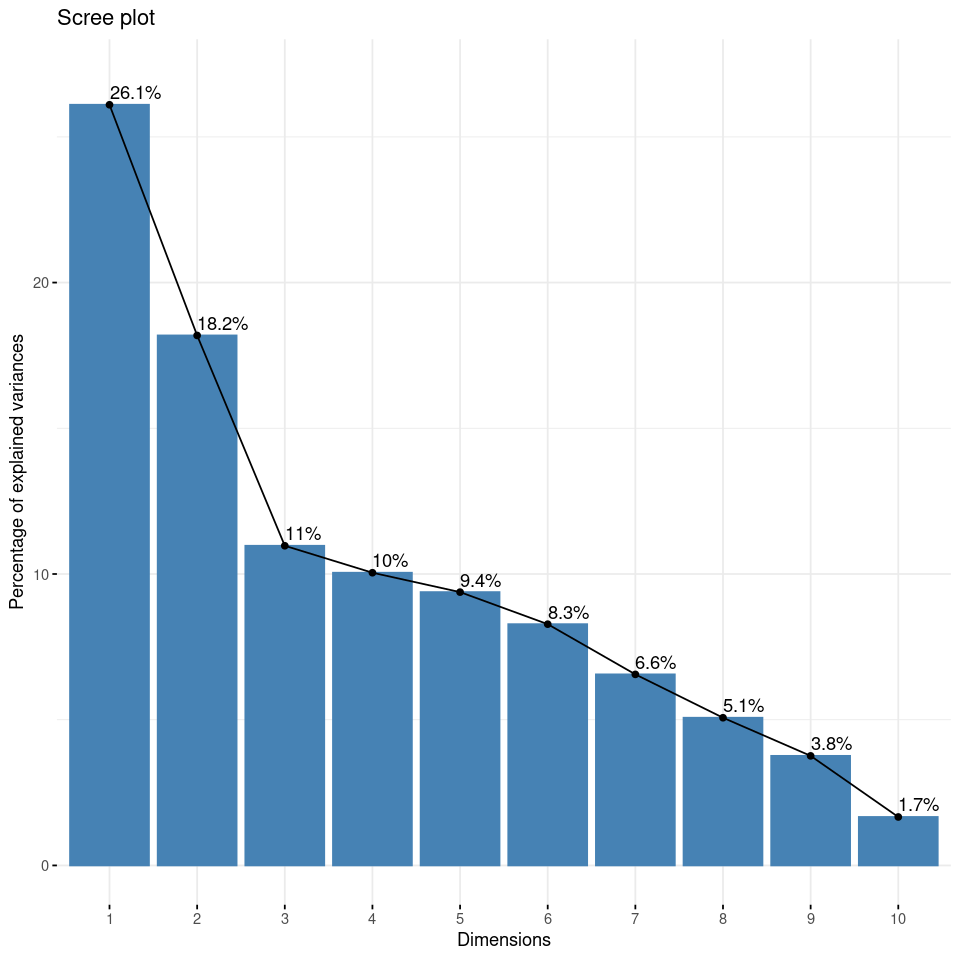

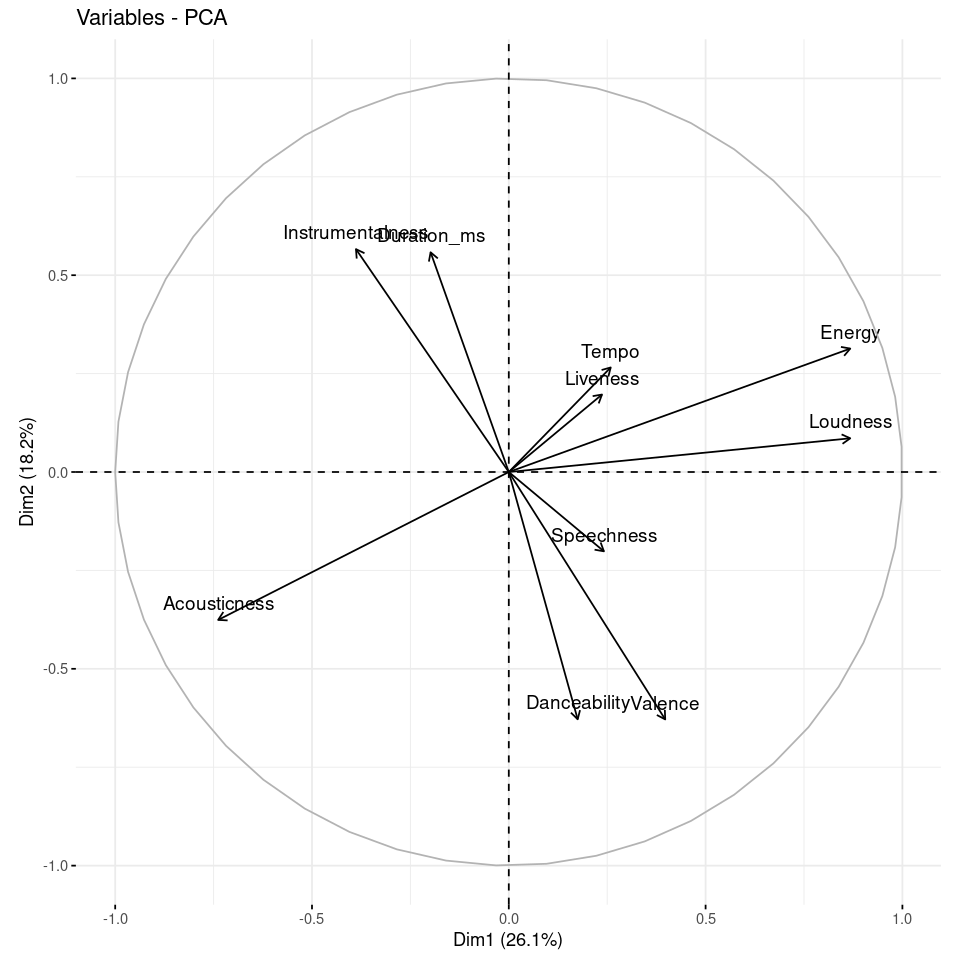

In [25]:
# la varianza è spalmata su tutte le features, tuttavia forse possiamo ridurre lo spazio da 10 a 8
# conferma delle correlazioni tra features viste precedentemente
get_eigenvalue(res.pca)
fviz_eig(res.pca, addlabels = TRUE,ylim=c(0,27))
fviz_pca_var(res.pca, col.var = "black")

# Undersampling

In [26]:
data <- undersampling_data(data, 1000)

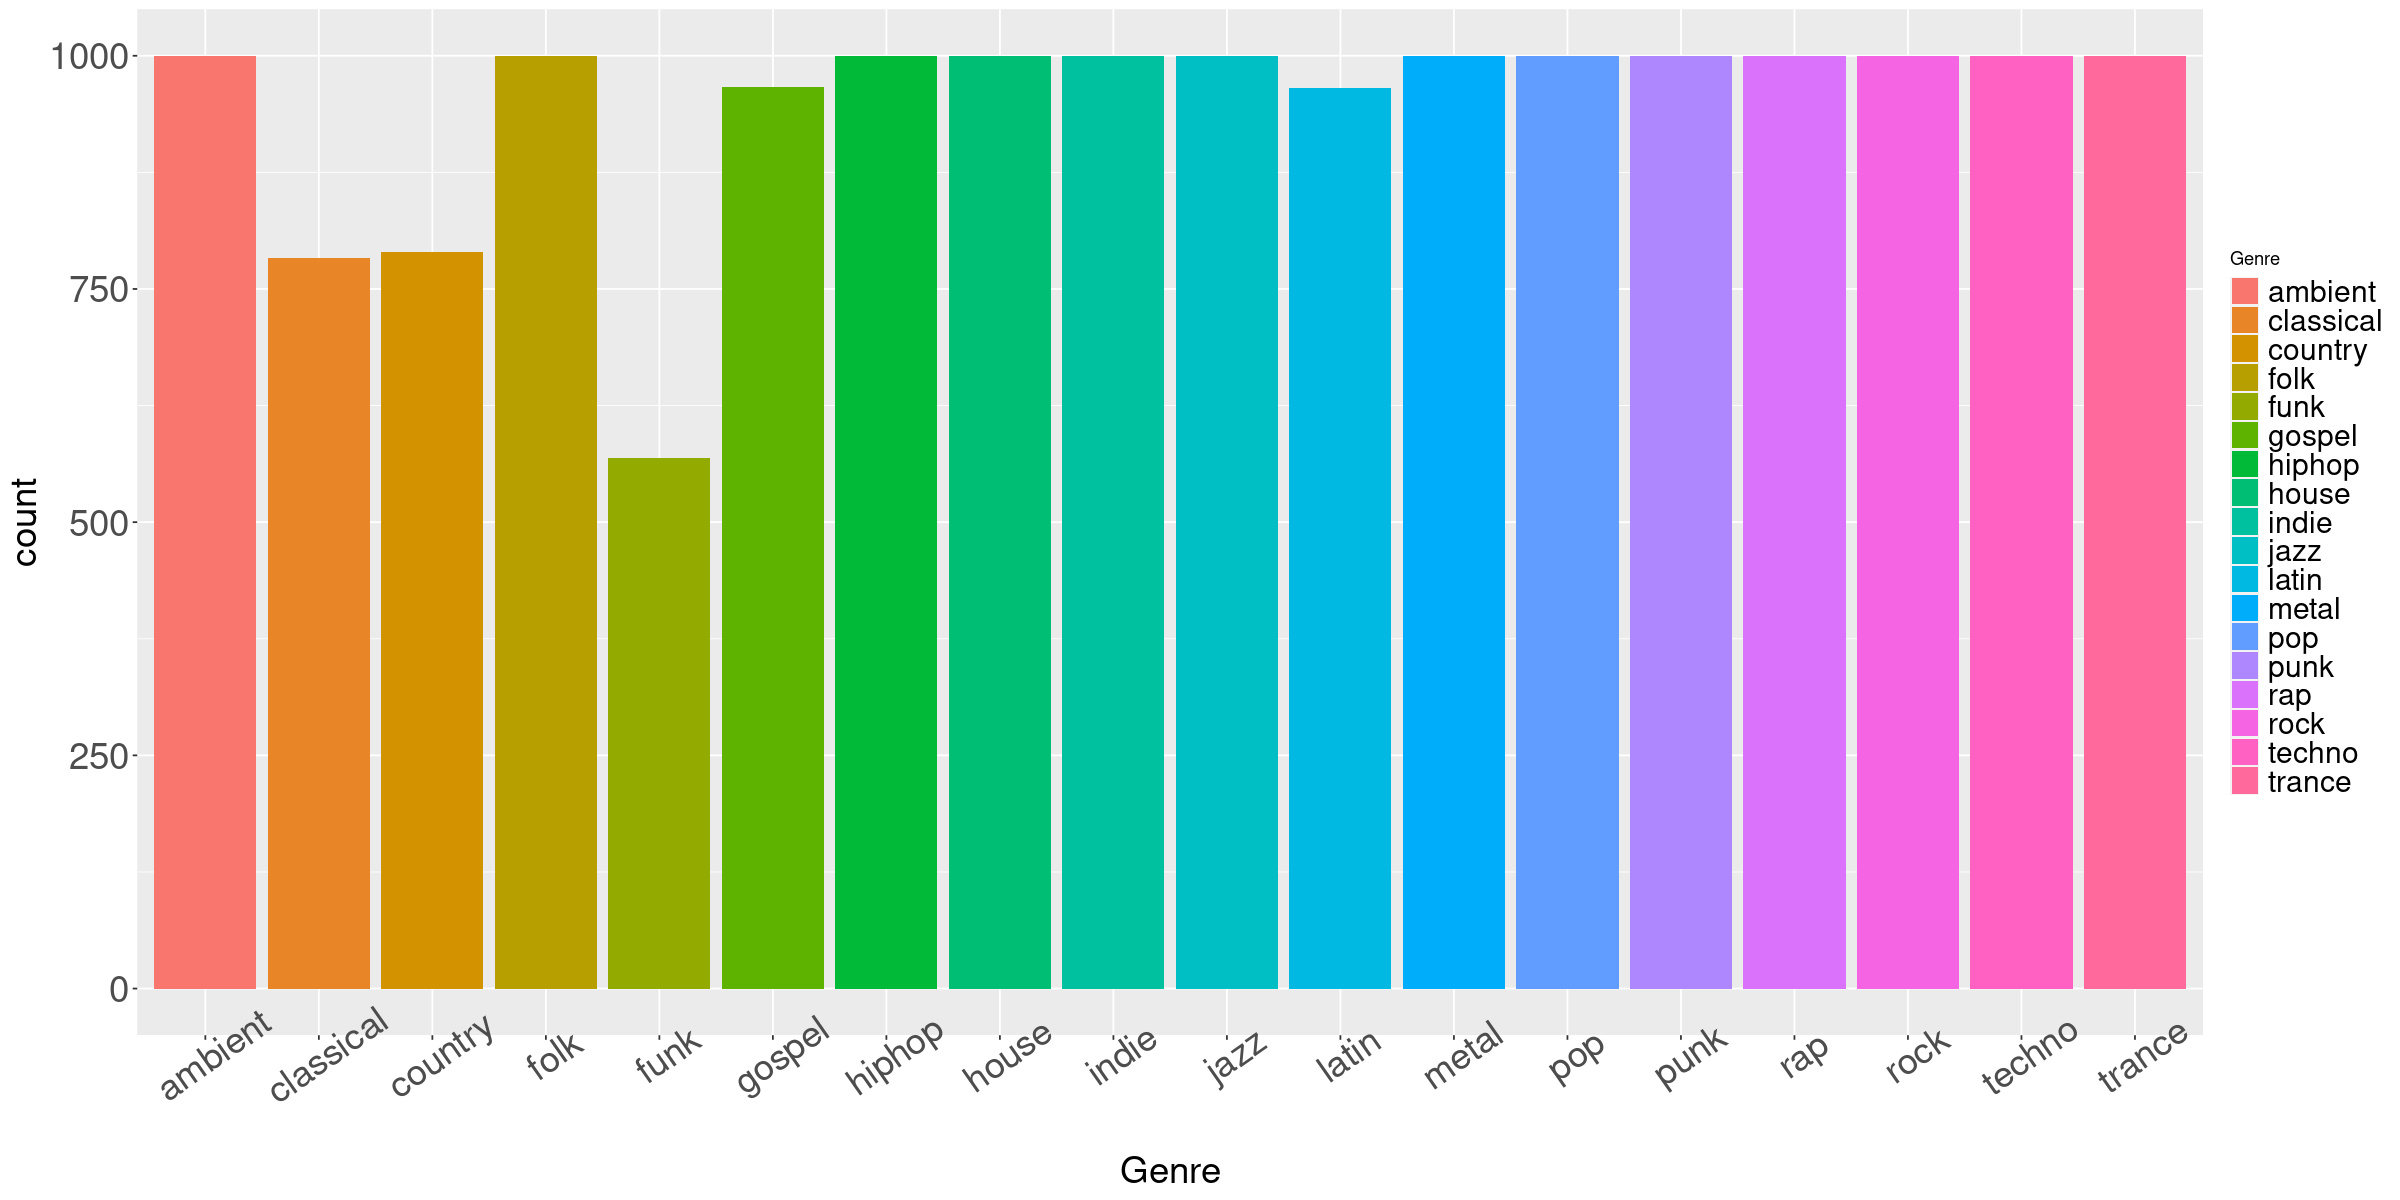

In [27]:
# verifica distribuzione dopo undersampling per pplotting
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data, aes(Genre)) + geom_bar(aes(fill = Genre)) +
    theme(legend.text=element_text(size=18), axis.text=element_text(size=rel(2)), axis.text.x=element_text(angle=35), axis.title=element_text(size=rel(2)))

# Split stratificato Training e Test set

In [28]:
train.index <- createDataPartition(data$Genre, p = 0.8, list = F)
train <- shuffle(data[train.index,])
test <- shuffle(data[-train.index,])

## Cross Validated and Tuning

In [29]:
# funzione per proiettare i dati in uno spazio nuovo (PCA)
pca_projection <- function(res.pca, data){
    data_trans <- data.frame(predict(res.pca, data)$coord)
    data_trans["Genre"] = data["Genre"]
    data_trans["Key"] = data["Key"]
    data_trans["Mode"] = data["Mode"]
    data_trans["time_signature"] = data["time_signature"] 
    return(data_trans)
}

In [30]:
#funzione SMOTE
smote <- function(training_f, minor_genres, top_genre ) {
    # faccio lo smoothing tra la top class e la classe corrente, poi straggo i samples della classe corrente
    # il motivo è che non ho capito come fare lo smoothing multiclass
    smoted_training_f = data.frame()
    for (genre in minor_genres) {
        temp <- training_f[training_f$Genre %in% c(top_genre, genre), ]
        temp <- droplevels(temp)
      
        num_rows_topGenre <- nrow(temp[temp$Genre == top_genre, ])
        num_rows_genre <-  nrow(temp[temp$Genre == genre, ])

        rate=0.7 # quanto vuoi avvicini alla classe top? 0.7 = voglio che raggiunga il 70% dei suoi samples
        goal = rate*num_rows_topGenre 
        p = ((goal - num_rows_genre)*100)/num_rows_genre   # parametro di perc.over se considerasse anche valori non multipli di 100
        #  arrotondameto di p al multiplo di 100 più vicino se supera un resto pari a rest_treshold
        rest_trehsold = 65
        if((p %% 100)>rest_trehsold)
            p = p - (p%%100) + 100
        
        smotato <-SMOTE(Genre ~ ., temp, perc.over = p)   #k puo servire per tunare
        smoted_training_f <- rbind(smotato[smotato$Genre == genre,], smoted_training_f)
    }
    # aggiungo smoted_training_f tutti i samples delle classi non considerate sopra
    for (genre in genres) {
        if (!(genre %in% minor_genres)) {
             smoted_training_f <- rbind(training_f[training_f$Genre == genre,], smoted_training_f)
        }
    }
   # plot(table(smoted_training_f$Genre))
    return(smoted_training_f)
}

In [31]:
# funzione naive bayes
nb <- function(x_train, y_train, x_validation, y_validation){
    nb_model = naiveBayes(x_train, y_train)
    Predict <- predict(nb_model, x_validation)
    cm <- confusionMatrix(Predict, y_validation)
    return(cm)
}

In [32]:
#funzione random forest
rf <- function(x_train, y_train, x_validation, y_validation){
    rf_model <- randomForest(x_train, y_train)
    Predict <- predict(rf_model, x_validation)
    cm <- confusionMatrix(Predict, y_validation)
    return(cm)
}

In [33]:
# funzione che implementa una rete neurale
nn <- function(x_train, y_train, x_validation, y_validation){
    # seleziono le variabili numeriche
    x_train_NN <- x_train[, setdiff(colnames(x_train), categorical_vars)]    
    x_validation_NN <- x_validation[, setdiff(colnames(x_validation), categorical_vars)]  
    
    # seleziono le variabili categoriche e applico l'one-hot encoding e le rimetto insieme alle numeriche
    z <- data.frame(one_hot(as.data.table(x_train[, c("Mode","Key","time_signature")])))
    for(colonna in colnames(z))
        x_train_NN[colonna] = z[colonna]
    z <- data.frame(one_hot(as.data.table(x_validation[, c("Mode","Key","time_signature")])))
    for(colonna in colnames(z))
        x_validation_NN[colonna] = z[colonna]

    # one-hot encoding delle y
    y_train_onehot <- one_hot(as.data.table(y_train))
    y_validation_onehot <- one_hot(as.data.table(y_validation)) 

    # costruisco rete neurale 
    output_units = length(unique(data$Genre)) 
    n_features = ncol(x_train_NN)
    model <- keras_model_sequential() 
    model %>% 
    layer_dense(units = 32, activation = 'relu', input_shape = c(n_features)) %>% 
    layer_dropout(rate = 0.4) %>% 
    layer_dense(units = 16, activation = 'relu') %>%
    layer_dense(units = 8, activation = 'relu') %>%
    layer_dense(units = 4, activation = 'relu') %>%
    layer_dense(units = output_units, activation = 'softmax')

    model %>% compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer_rmsprop(),
        metrics = c('accuracy')
    )

    # training rete neurale
    history <- model %>% fit(
        data.matrix(x_train_NN), data.matrix(y_train_onehot), 
        epochs = 70, batch_size = 128, 
        validation_data = list(data.matrix(x_validation_NN), data.matrix(y_validation_onehot))
    )

     #options(repr.plot.width=15, repr.plot.height=15)
     #print(plot(history))

    # prediction 
    pred <- model %>% predict(data.matrix(x_validation_NN), batch_size = 128)
    
    # ottengo confusion matrix
    true_df <- data.frame(y_validation_onehot)
    pred_df <- data.frame(pred)
    
    new_colnames <- sub(".*_", "", colnames(true_df))
    for(i in 1:ncol(true_df)){
        colnames(true_df)[i] <- new_colnames[i]
        colnames(pred_df)[i] <- new_colnames[i]
    }
    for (i in 1:nrow(true_df)){
        for (col in colnames(true_df)){
            if(true_df[i,col]==1){
                true_df[i,"result"] <-col
                break
    }}}
    for (i in 1:nrow(pred_df)){
        max = max(pred_df[i,1:length(new_colnames)])
        for (col in colnames(pred_df)){
            if(pred_df[i,col]== max){
                pred_df[i,"result"] <-col
                break
    }}}
    
    cm <- confusionMatrix(factor(pred_df$result), factor(true_df$result), mode = "prec_recall") 
    return(list(pred, cm))
}

In [34]:
# creo 10 folds stratificati
nfolds <- 10
folds_index <- createFolds(train$Genre, nfolds, returnTrain = T)
fold_list <- list()
for (i in rep(1:nfolds)) 
   fold_list[[i]] <- train[-folds_index[[i]],]

# check distribution of target
#prop.table(table(fold_list[[1]]$Genre))    # per ogni fold

In [35]:
# ottengo genere top per poter basarmi su quello per fare oversampling
genres_df <- count(data, "Genre")
genres_df <- genres_df[order(-genres_df$freq), ]
top_genre <- as.character(genres_df[1, "Genre"])
top_genre_count <- as.numeric(genres_df[1, "freq"])

# get minor genres (<70% samples rispetto alnrow top genre)
minor_genres_df <- genres_df[genres_df$freq < (as.numeric(top_genre_count) * 0.7), ]
minor_genres <- list()
for (el in minor_genres_df[, "Genre"]) {
    minor_genres <- append(minor_genres, el)
}

In [36]:
# Cross validation usata per fare tuning su parametri di undersampling, oversampling e PCA
CV <- function(is_pca, is_smote, is_nb, is_rf, is_nn){
    rf_results <- c()
    nb_results <- c()
    nn_results <- c()
    
    for (i in rep(1:nfolds)) {
        training_f <- data.frame()
        validation_f <- data.frame()
        
        # a rotazione uso 9 folds per il training e 1 per il validation 
        for (j in rep(1:nfolds)) {
            if (i != j) 
                training_f <- rbind(fold_list[[j]], training_f) 
            else
                validation_f <- fold_list[[j]] 
        }
        
        # PCA --------------------------------------------------------------
        if(is_pca){
            res.pca <- PCA(training_f[,numerical_vars], ncp=8, graph=FALSE)
            training_f <- pca_projection(res.pca, training_f)
            validation_f <- pca_projection(res.pca, validation_f)
        }
        
        # SMOTE solo sui training folds ------------------------------------
        if(is_smote){
            training_f <- smote(training_f, minor_genres, top_genre)
        }
        
        # ------------------------------------------------------------------
        predictors <- setdiff(colnames(training_f), c("Genre"))
        x_train = training_f[,predictors]
        y_train = training_f[, "Genre"]
        x_validation =  validation_f[, predictors]
        y_validation = validation_f$Genre
        
        #--------------------------------------------------------------------
        # Training ed evaluation. L'accuratezza di ogni modello viene salvata
        # nel rispettivo array
        if(is_nb){
            cm_nb <- nb(x_train, y_train, x_validation, y_validation)
            nb_results <- c(nb_results, cm_nb$overall["Accuracy"])
        }
        
        if(is_rf){
            cm_rf <- rf(x_train, y_train, x_validation, y_validation)
            rf_results <- c(rf_results, cm_rf$overall["Accuracy"])
        }
        
        if(is_nn){
            nn_out <- nn(x_train, y_train, x_validation, y_validation)
            nn_results <- c(nn_results, nn_out[[2]]$overall["Accuracy"])
        }
    }
    
    cat("average accuracy nb: ", mean(nb_results), "\n")
    cat("average accuracy rf: ", mean(rf_results), "\n")
    cat("average accuracy nn: ", mean(nn_results), "\n")
}

In [37]:
# warning dovutial fatto che spesso con la rete neurale non predice mai "rock"
CV(is_pca=TRUE, is_smote=FALSE, is_nb=TRUE, is_rf=TRUE, is_nn=TRUE)

Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(factor(pred_df$result), factor(true_df$result), :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(factor(pred_df$result), factor(true_df$result), :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(factor(pred_df$result), factor(true_df$result), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


average accuracy nb:  0.3525614 
average accuracy rf:  0.4588574 
average accuracy nn:  0.3773051 


In [38]:
#CV(is_pca=TRUE, is_smote=TRUE, is_nb=TRUE, is_rf=TRUE, is_nn=TRUE)

In [39]:
CV(is_pca=FALSE, is_smote=FALSE, is_nb=TRUE, is_rf=TRUE, is_nn=TRUE)

Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(factor(pred_df$result), factor(true_df$result), :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(factor(pred_df$result), factor(true_df$result), :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(factor(pred_df$result), factor(true_df$result), :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorte

average accuracy nb:  0.3588558 
average accuracy rf:  0.5032943 
average accuracy nn:  0.3644256 


In [40]:
#CV(is_pca=FALSE, is_smote=TRUE, is_nb=TRUE, is_rf=TRUE, is_nn=TRUE)

# Testing

#### Vengono usati parametri vincenti ottenuti nel tuning: undersampling delle classi fino a 1000 samples, no oversampling, no PCA

In [43]:
predictors <- setdiff(colnames(train), c("Genre"))
x_train <- train[, predictors]
y_train <- train[, c("Genre")]
x_test <- test[, predictors]
y_test <- test[, c("Genre")]

In [44]:
# true lables per multi ROC
trueLabels <- data.frame(one_hot(as.data.table(y_test)))
for(i in 1:ncol(trueLabels))
    colnames(trueLabels)[i] <- paste(sub("y_test_", "", colnames(trueLabels)[i]), "_true",  sep = "")

In [45]:
# Naive Bayes
nb_model = naiveBayes(x_train, y_train, type="raw")

nb_prob <- predict(nb_model, x_test, type="raw")
colnames(nb_prob) <- paste(colnames(nb_prob), "_pred_NB", sep = "")

nb_pred <- predict(nb_model, x_test)
nb_cm <-confusionMatrix(nb_pred, y_test, mode = "prec_recall")

In [46]:
nb_cm

Confusion Matrix and Statistics

           Reference
Prediction  ambient classical country folk funk gospel hiphop house indie jazz
  ambient        62        14       0   18    1      3      2     6     6   11
  classical      67       130       3   36    2      6      1     0     7   27
  country         1         2     135   42    9     20     21    52    75   12
  folk            2         4       3   24    0      7      2     2     5    8
  funk            0         0       0    1   24      0      3     2     3   17
  gospel          2         1       2    6    7     72      6     2     4   13
  hiphop          0         0       0    6    4      3     24     5     3    5
  house           6         0       0    1    9      9      5    14     5   11
  indie           1         2       2   11    0      9      1     5     8    1
  jazz            5         3       1   11   12      9      7     7     6   36
  latin           0         0       7   22   13     25      7     6    14   1

In [47]:
# Random Forest
rf_model <- randomForest(x_train, y_train)
rf_prob <- predict(rf_model, x_test, type="prob")
colnames(rf_prob) <- paste(colnames(rf_prob), "_pred_RF", sep = "")

rf_pred <- predict(rf_model, x_test)
rf_cm <- confusionMatrix(rf_pred, y_test, mode = "prec_recall")

In [48]:
rf_cm

Confusion Matrix and Statistics

           Reference
Prediction  ambient classical country folk funk gospel hiphop house indie jazz
  ambient       126        20       0   16    3      0      2    10     5   13
  classical      16       119       0    8    0      7      1     1     1    3
  country         0         0     106    8    0      0      3     9    20    2
  folk            3         6       5   67    2     10      6     0    14   16
  funk            1         0       0    3   41      2      3     2     5    8
  gospel          0         0       6   10    1    120      2     1    11    4
  hiphop          1         0       1    5    4      7    106    10     8   14
  house          12         0       3    3    7      9     15    77    10    7
  indie           1         3      12    9    2      5      2     7    39    2
  jazz           14         8       1   20   23      7      5     6    13   96
  latin           0         0       5   11   11     15      4     2     8   1

In [49]:
# Neural Network
nn_output <- nn(x_train, y_train, x_test, y_test)
nn_prob <- data.frame(nn_output[[1]])
new_cols <-sub("y_test_", "", colnames(data.frame(one_hot(as.data.table(y_test)))))
for(i in 1:ncol(nn_prob))
    colnames(nn_prob)[i] <- paste(new_cols[[i]], "_pred_NN",  sep = "")
nn_cm <- nn_output[[2]]

In [50]:
nn_cm

Confusion Matrix and Statistics

           Reference
Prediction  ambient classical country folk funk gospel hiphop house indie jazz
  ambient       104         8       0   11    5      0      1     8     4   11
  classical      29       128       0   20    1      7      1     0     2   17
  country         0         2     100   19    7     10      4    16    33    9
  folk           10        11       8   59    3     19      3     1    22   25
  funk            1         0       0    1    3      4      4     1     0    1
  gospel          0         2       6   20    3     80      1     1    10   10
  hiphop          0         0       0    9    9     12    102    17     8   11
  house           3         0       1    2   14      5     11    40     7    9
  indie           1         0       1    0    0      0      0     0     3    0
  jazz            4         5       0   16   16     10     12     8    11   63
  latin           0         0       5   13   11     24      6     2     8   1

In [51]:
ROC.data = data.frame(cbind(trueLabels,nb_prob,rf_prob,nn_prob))

In [52]:
# ROC/PR
ROC.results = multi_roc(ROC.data, force_diag=T)
ROC.results.plot <- plot_roc_data(ROC.results)

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning me

### Plot ROC

In [53]:
options(repr.plot.width=12, repr.plot.height=12)

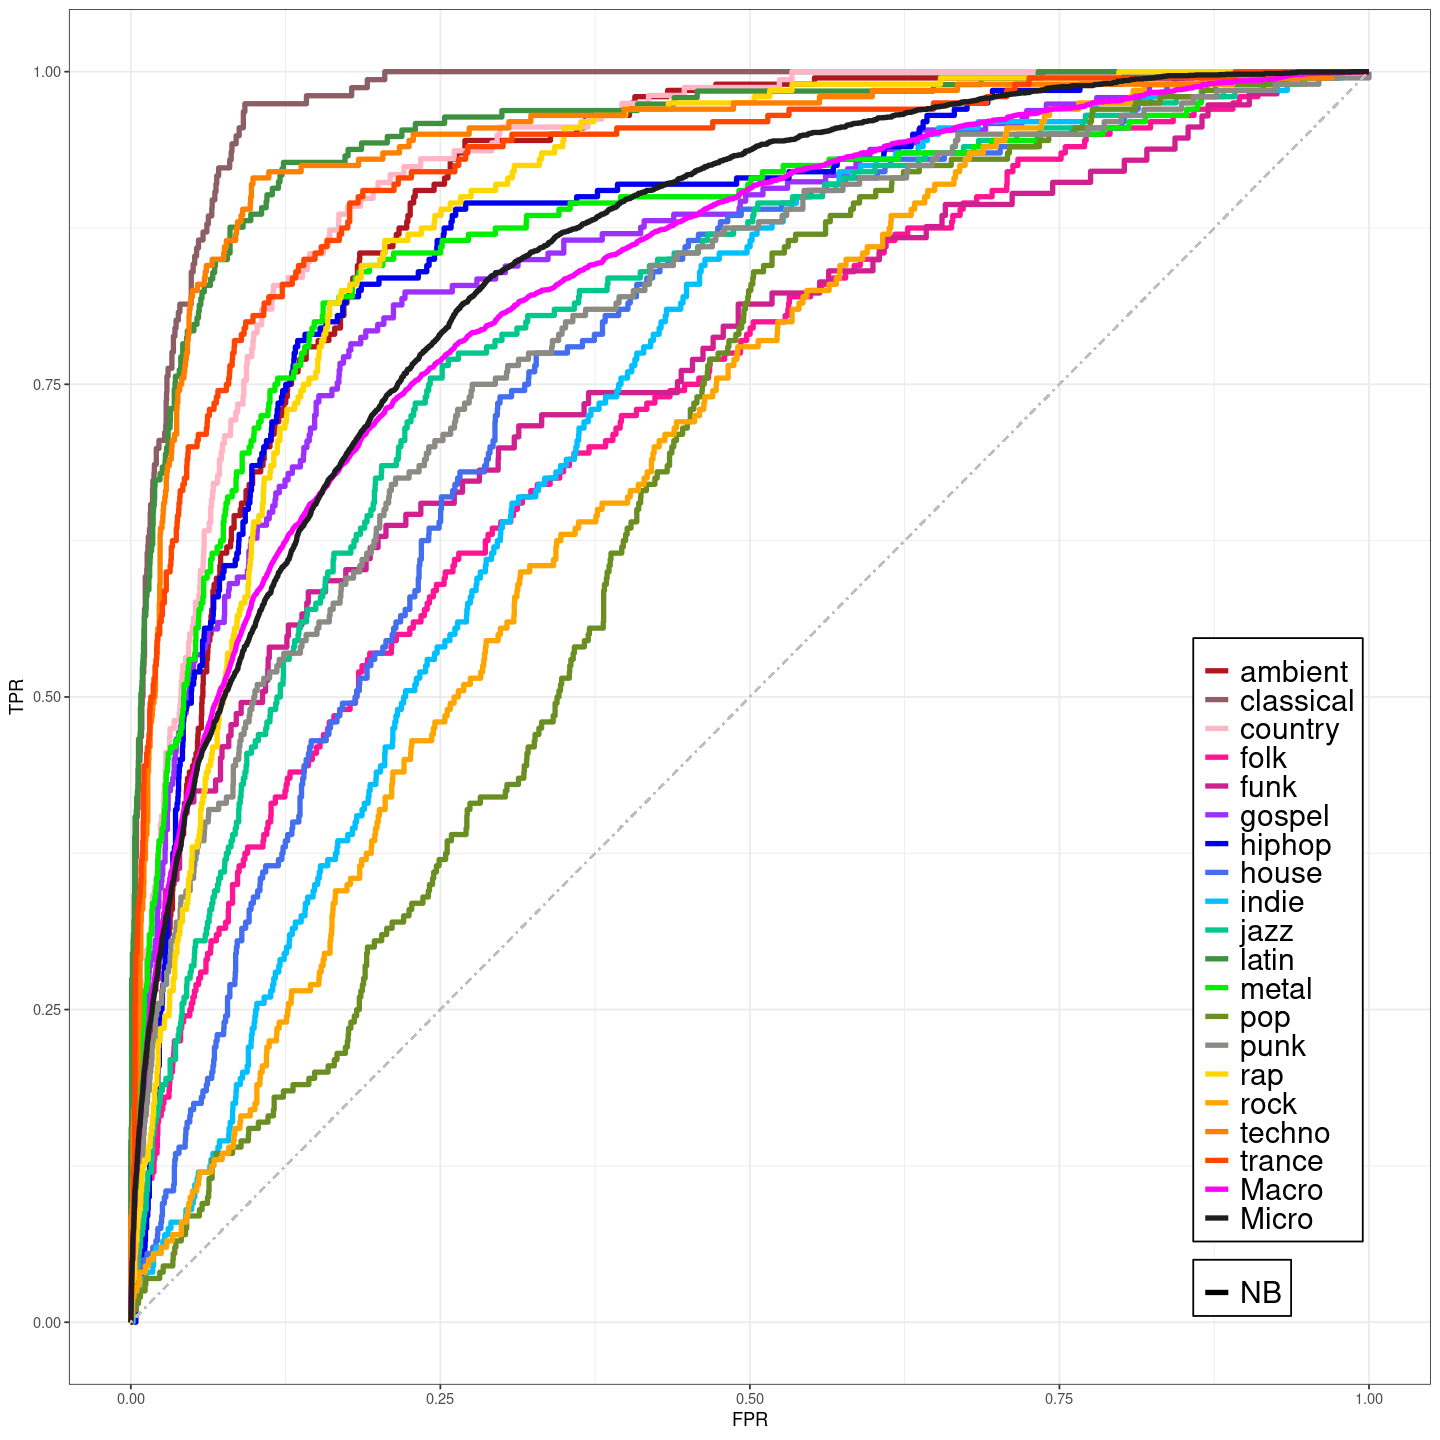

In [54]:
# plot ROC NB
ggplot(ROC.results.plot[ROC.results.plot$Method=="NB",], aes(x = 1-Specificity, y=Sensitivity)) +
  xlab("FPR") + ylab("TPR") +
  geom_path(aes(color = Group, linetype=Method), size=1.5) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
               colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  scale_color_manual(values = c("#B0171F", "#8B5F65", "#FFB5C5", "#FF1493", "#D02090", "#9B30FF","#0000EE", "#436EEE", "#00BFFF", "#00C78C", "#3D9140", "#00EE00","#6B8E23", "#8B8B83", "#FFD700", "#FFA500", "#FF7F00", "#FF4500","#FF00FF", "#1E1E1E")) + 
  theme(plot.title = element_text(hjust = 0.5), 
        legend.justification=c(1, 0), legend.position=c(.95, .05),
        legend.title=element_blank(), 
        legend.text=element_text(size=18),
        legend.background = element_rect(fill=NULL, size=0.5, linetype="solid", colour ="black"))
  


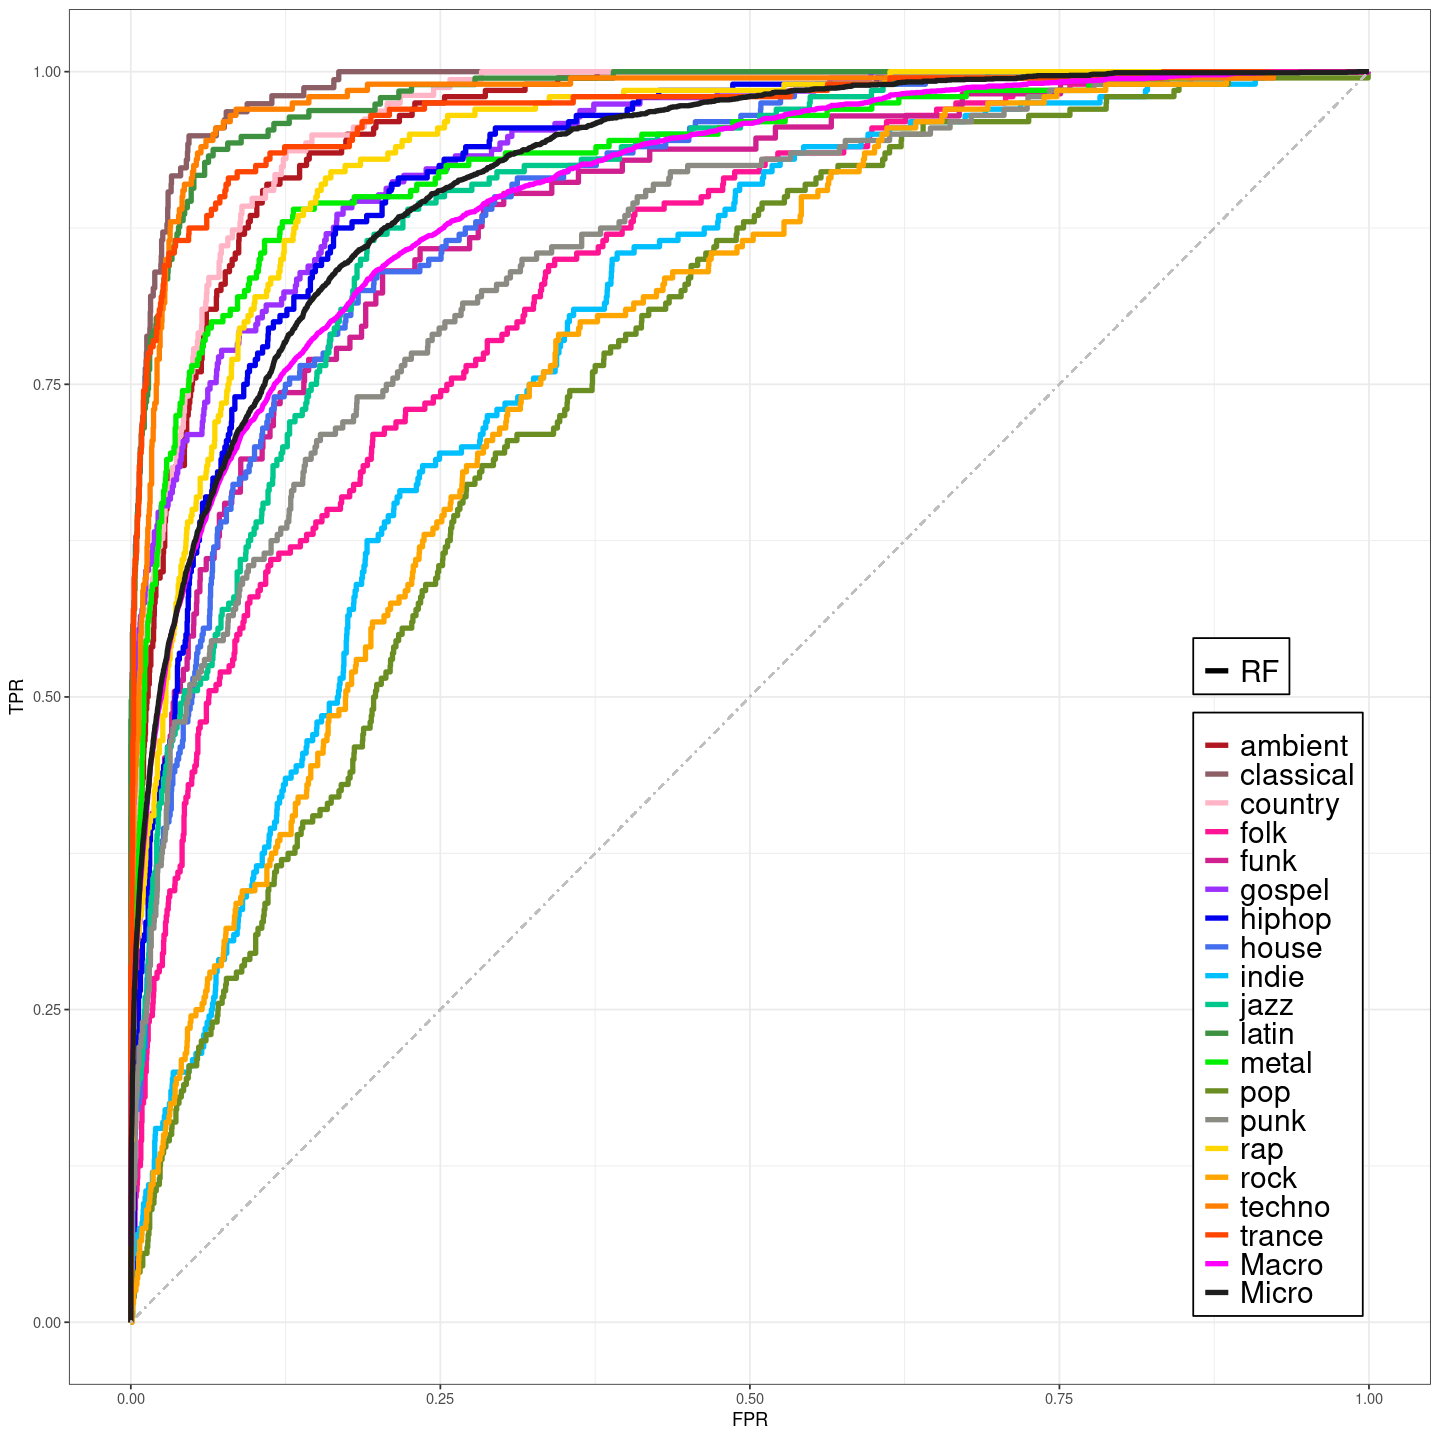

In [55]:
# plot ROC RF
ggplot(ROC.results.plot[ROC.results.plot$Method=="RF",], aes(x = 1-Specificity, y=Sensitivity)) +
  xlab("FPR") +
  ylab("TPR") +
  geom_path(aes(color = Group, linetype=Method), size=1.5) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
               colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  scale_color_manual(values = c("#B0171F", "#8B5F65", "#FFB5C5", "#FF1493", "#D02090", "#9B30FF","#0000EE", "#436EEE", "#00BFFF", "#00C78C", "#3D9140", "#00EE00","#6B8E23", "#8B8B83", "#FFD700", "#FFA500", "#FF7F00", "#FF4500","#FF00FF", "#1E1E1E")) + 
  theme(plot.title = element_text(hjust = 0.5), 
        legend.justification=c(1, 0), legend.position=c(.95, .05),
        legend.title=element_blank(), 
        legend.text=element_text(size=18),
        legend.background = element_rect(fill=NULL, size=0.5, linetype="solid", colour ="black"))

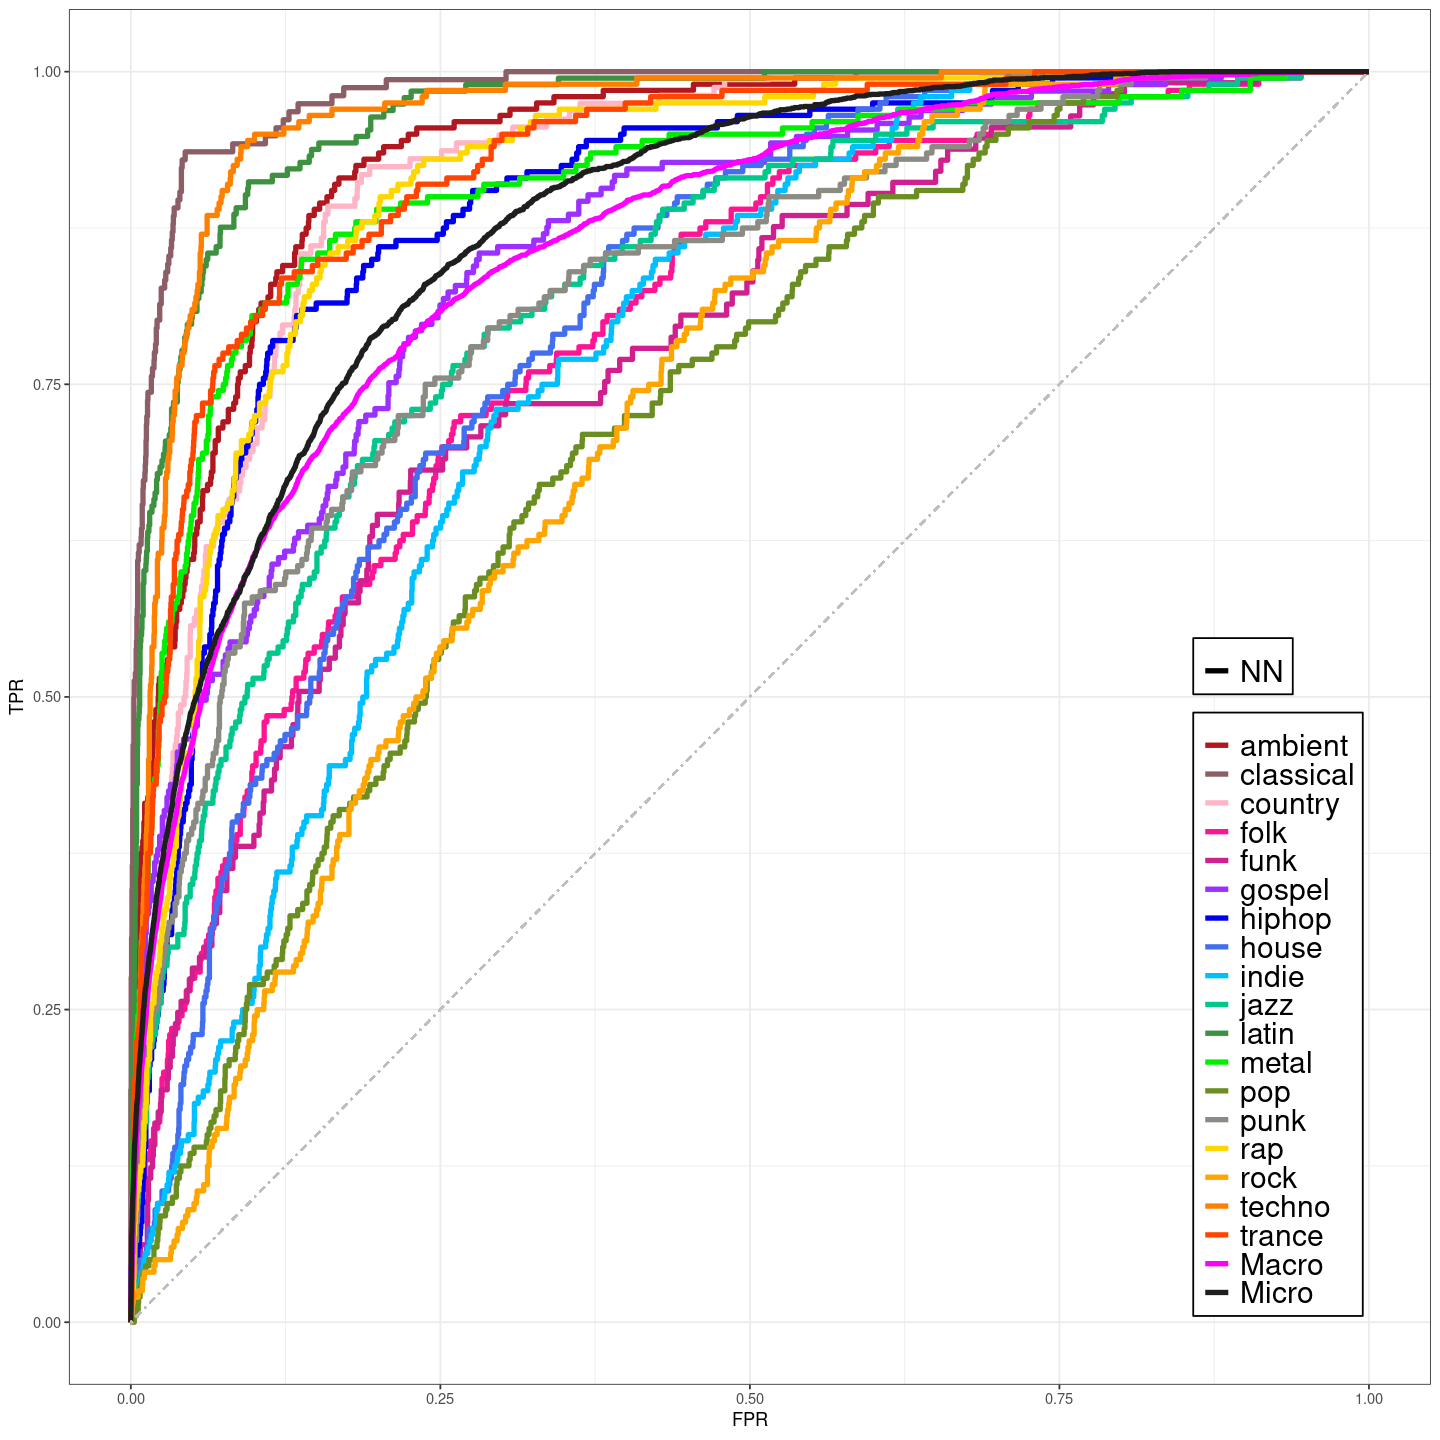

In [56]:
# plot ROC NN
ggplot(ROC.results.plot[ROC.results.plot$Method=="NN",], aes(x = 1-Specificity, y=Sensitivity)) +
  xlab("FPR") +
  ylab("TPR") +
  geom_path(aes(color = Group, linetype=Method), size=1.5) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
               colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  scale_color_manual(values = c("#B0171F", "#8B5F65", "#FFB5C5", "#FF1493", "#D02090", "#9B30FF","#0000EE", "#436EEE", "#00BFFF", "#00C78C", "#3D9140", "#00EE00","#6B8E23", "#8B8B83", "#FFD700", "#FFA500", "#FF7F00", "#FF4500","#FF00FF", "#1E1E1E")) + 
  theme(plot.title = element_text(hjust = 0.5), 
        legend.justification=c(1, 0), legend.position=c(.95, .05),
        legend.title=element_blank(),
        legend.text=element_text(size=18),
        legend.background = element_rect(fill=NULL, size=0.5, linetype="solid", colour ="black"))

In [57]:
options(repr.plot.width=10, repr.plot.height=8)

### Macro measures

[1] 0.8369373

[1] 0.9044764

[1] 0.8619264

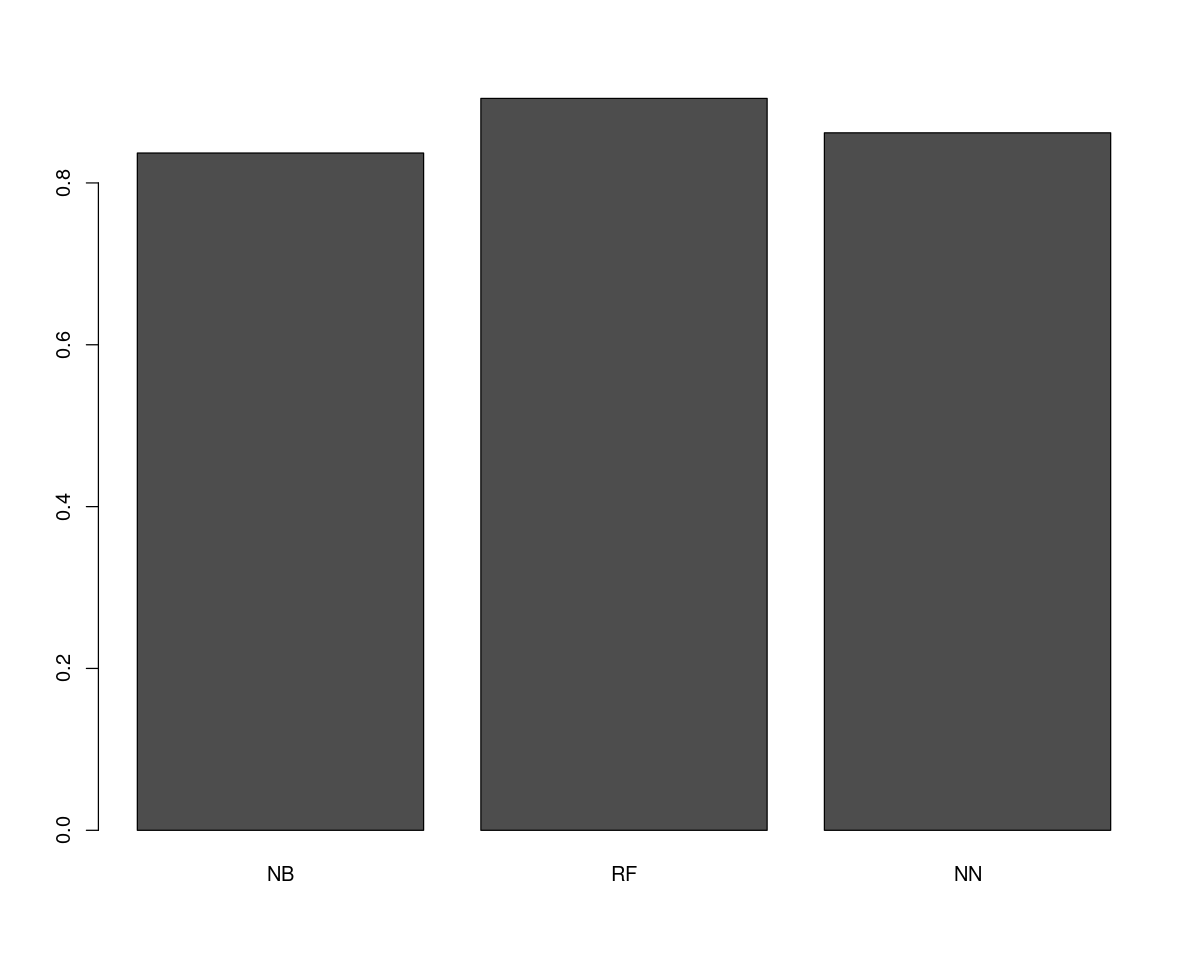

In [58]:
# print AUC macro
ROC.results$AUC$NB$macro
ROC.results$AUC$RF$macro
ROC.results$AUC$NN$macro

macro.plot = cbind(ROC.results$AUC$NB$macro, ROC.results$AUC$RF$macro, ROC.results$AUC$NN$macro)
colnames(macro.plot) = c("NB", "RF", "NN")
barplot(macro.plot)

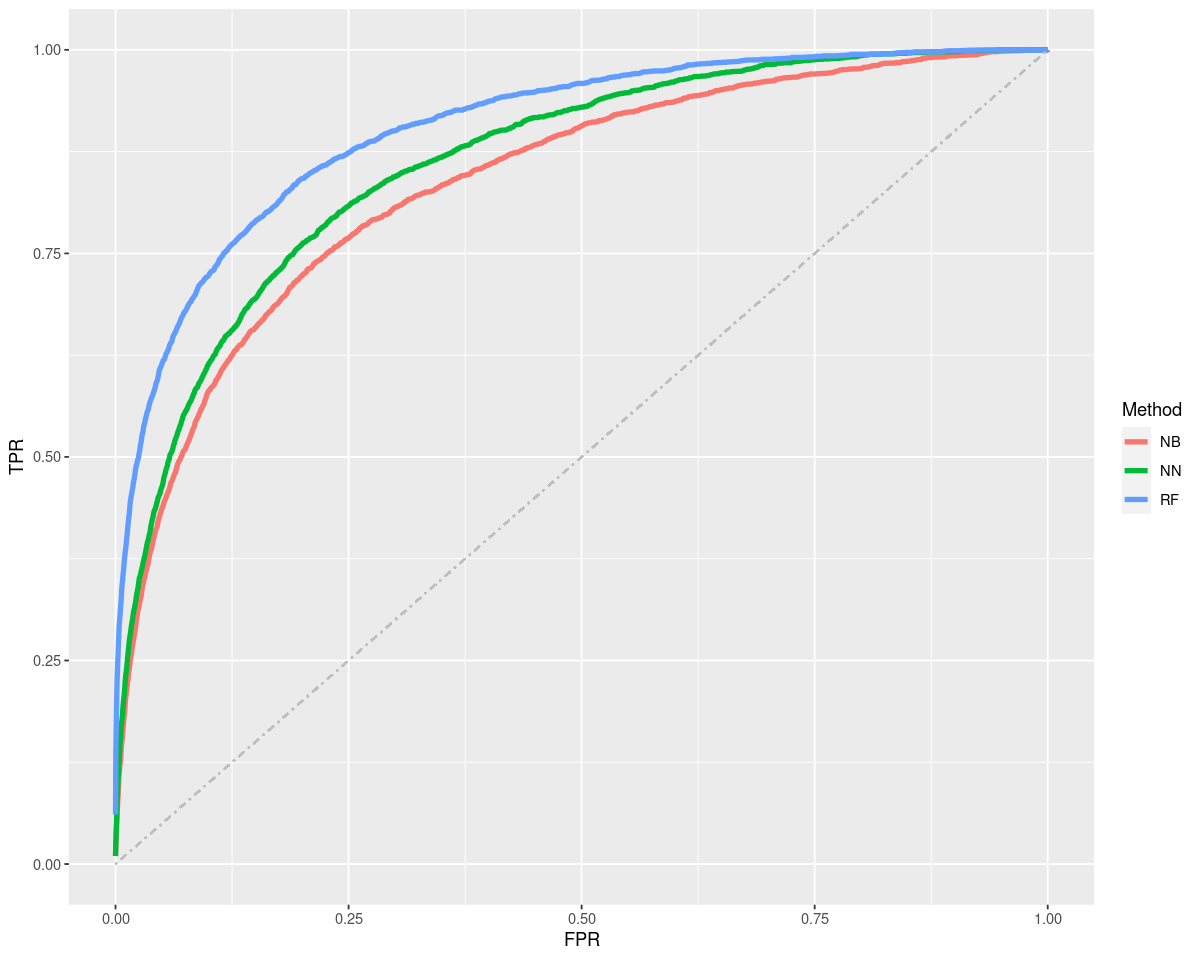

In [59]:
# plot riassuntivo delle macro per tutti e tre i modelli
ROC.results.merge = cbind(1-ROC.results$Specificity$NB$macro, ROC.results$Sensitivity$NB$macro, "NB")
ROC.results.merge = rbind(ROC.results.merge, cbind(1-ROC.results$Specificity$RF$macro, ROC.results$Sensitivity$RF$macro, "RF"))
ROC.results.merge = rbind(ROC.results.merge, cbind(1-ROC.results$Specificity$RF$macro, ROC.results$Sensitivity$NN$macro, "NN"))
colnames(ROC.results.merge) = c("FPR", "TPR", "Method")
ROC.results.merge = data.frame(ROC.results.merge)
ROC.results.merge$Method = factor(ROC.results.merge$Method)
ROC.results.merge$FPR = as.numeric(as.character(ROC.results.merge$FPR))
ROC.results.merge$TPR = as.numeric(as.character(ROC.results.merge$TPR))

ggplot(data=ROC.results.merge, aes(x=FPR, y=TPR, group = Method, colour = Method)) +
  geom_line(size = 1.5) + geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1),colour='grey', linetype = 'dotdash')


In [60]:
nb_cm_df = data.frame(nb_cm$byClass)
nb_cm_df[is.na(nb_cm_df)] = 0
rf_cm_df = data.frame(rf_cm$byClass)
rf_cm_df[is.na(rf_cm_df)] = 0
nn_cm_df = data.frame(nn_cm$byClass)
nn_cm_df[is.na(nn_cm_df)] = 0

precision.measures = c(mean(nb_cm_df$Precision), mean(nb_cm_df$Precision), mean(nb_cm_df$Precision))
recall.measures = c(mean(nb_cm_df$Recall), mean(rf_cm_df$Recall), mean(nn_cm_df$Recall))
f1.measure = c(mean(nb_cm_df$F1), mean(rf_cm_df$F1), mean(nn_cm_df$F1))
model.labels = c("NB", "RF", "NN")
performance.measures = data.frame(model.labels, precision.measures, recall.measures, f1.measure)
performance.measures = cbind(performance.measures, c(ROC.results$AUC$NB$macro, ROC.results$AUC$RF$macro, ROC.results$AUC$NN$macro), 
                             c(nb_cm$overall[1], rf_cm$overall[1], nn_cm$overall[1]))
colnames(performance.measures) = c("Model", "Precision", "Recall", "F1", "AUC", "Acc")

In [61]:
# tabella per costruire plot per le misure dei modelli
model.labels = c("NB", "NB", "NB", "NB", "NB", "RF", "RF", "RF", "RF", "RF", "NN", "NN", "NN", "NN", "NN")
perf.measure.labels = c("Prec", "Rec", "F1", "AUC", "Acc", "Prec", "Rec", "F1", "AUC", "Acc", "Prec", "Rec", "F1", "AUC", "Acc")
perf.measure.values = c(mean(nb_cm_df$Precision), mean(nb_cm_df$Recall), mean(nb_cm_df$F1), ROC.results$AUC$NB$macro, nb_cm$overall[1],
                        mean(rf_cm_df$Precision), mean(rf_cm_df$Recall), mean(rf_cm_df$F1), ROC.results$AUC$RF$macro, rf_cm$overall[1],
                        mean(nn_cm_df$Precision), mean(nn_cm_df$Recall), mean(nn_cm_df$F1), ROC.results$AUC$NN$macro, nn_cm$overall[1])
performance.measures.plot = data.frame(model.labels, perf.measure.labels, perf.measure.values)
colnames(performance.measures.plot) = c("Model", "Measure", "Value")
performance.measures.plot$Model = factor(performance.measures.plot$Model, levels=c("NB", "RF", "NN"))
performance.measures.plot$Measure = factor(performance.measures.plot$Measure, levels=c("Prec", "Rec", "F1", "AUC", "Acc"))

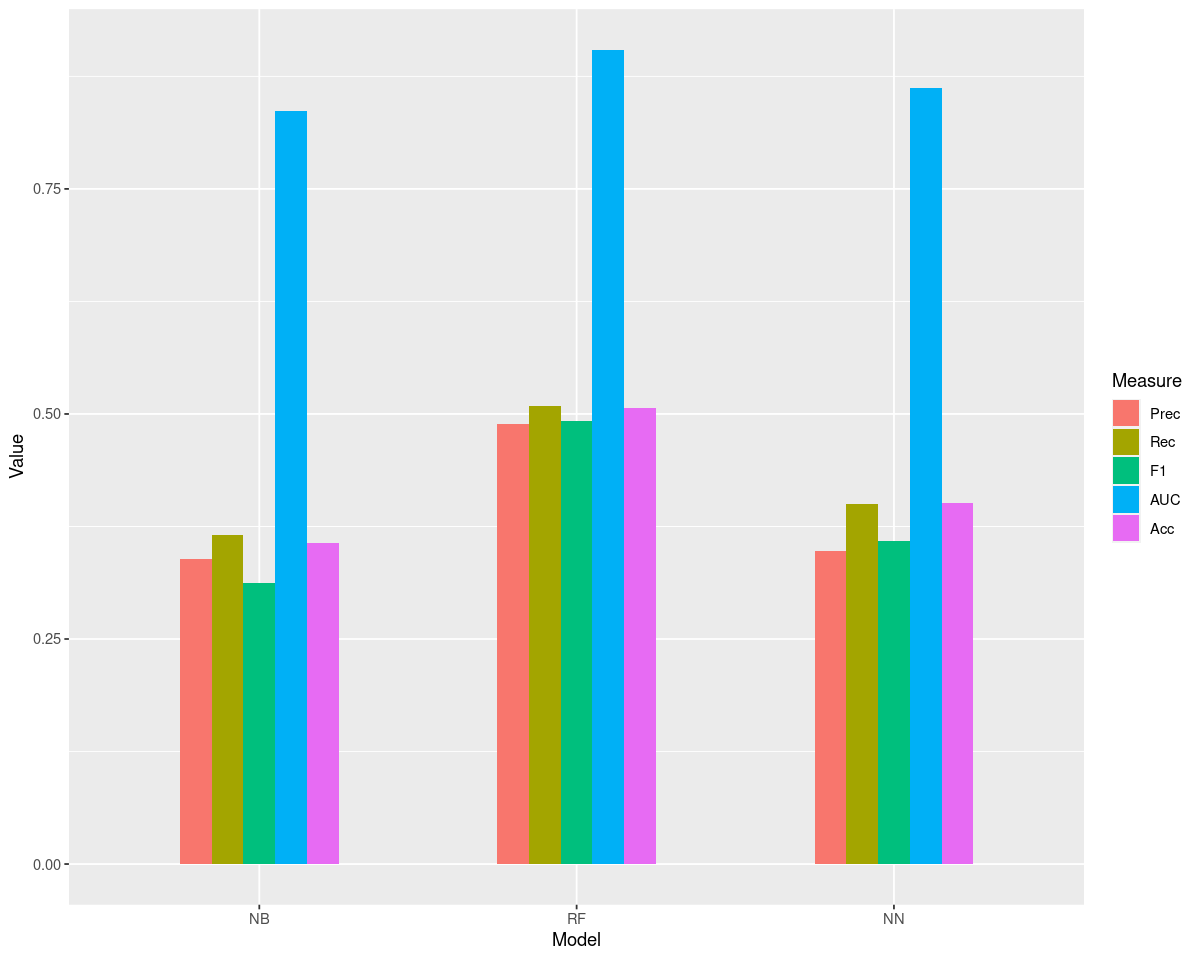

In [62]:
ggplot(performance.measures.plot, aes(fill=Measure, y=Value, x=Model)) + 
  geom_bar(position="dodge", stat="identity", width=0.5)


In [63]:
#### Accuracy
nb_cm$overall[1]
rf_cm$overall[1]
nn_cm$overall[1]

Accuracy 
0.3562848

Accuracy 
0.5068854

Accuracy 
0.4005274